<a href="https://colab.research.google.com/github/Jackson00Han/Time-Series-Training/blob/main/Copy_of_multivariate_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

Thie project aims to illustrate the multivariate time series forecasting methods. Specifically, we will predict the energy demand and price for the next 24 hours in Spain using the following approaches:

CNN-LSTM-DNN

*   Single-Step Single-Output + Autoregressive
*   Single-Step Multi-Output + Autoregressive
*   Multi-Step Multi-Output (single shot)

XGBoost (single step multi-output)











##  1-Data Preprocessing


In [2]:
## Set up

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

In [3]:
df = pd.read_csv('energy_dataset.csv', usecols=['time','total load actual', 'price actual'])
print(f'The shape of the dataset is {df.shape}\n')
print(df.info())

The shape of the dataset is (35064, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time               35064 non-null  object 
 1   total load actual  35028 non-null  float64
 2   price actual       35064 non-null  float64
dtypes: float64(2), object(1)
memory usage: 821.9+ KB
None


In [4]:
df.head()

,time,total load actual,price actual
0,2015-01-01 00:00:00+01:00,25385.0,65.41
1,2015-01-01 01:00:00+01:00,24382.0,64.92
2,2015-01-01 02:00:00+01:00,22734.0,64.48
3,2015-01-01 03:00:00+01:00,21286.0,59.32
4,2015-01-01 04:00:00+01:00,20264.0,56.04


In [5]:
## Managing Time Column

# Convert to datetime
df['time'] = pd.to_datetime(df['time'], utc=True)
df['time'] = df['time'].dt.strftime('%Y-%m-%d %H:%M:%S')
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Ensure time series is in ascending order
df.sort_index(inplace=True)

#Calculate time differences
time_diffs = df.index.to_series().diff()
irregularities = time_diffs[time_diffs != time_diffs.mode()[0]][1:]             #Identify any irregularities, apart from the first row
if irregularities.empty:
    print("No irregularities found.")
else:
    print("Irregularities found at:")
    print(irregularities)

No irregularities found.


In [6]:
# We only use the most recent Three years of data for training, as it it sufficient for our purposes and helps to reduce computation time.
df = df[df.index >= '2016-01-01 00:00:00'].copy()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26303 entries, 2016-01-01 00:00:00 to 2018-12-31 22:00:00
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total load actual  26294 non-null  float64
 1   price actual       26303 non-null  float64
dtypes: float64(2)
memory usage: 616.5 KB


In [8]:
## Handling Missing Values

non_numeric_values = ['?', 'N/A', '-', ''] # List of non-numeric values to replace

for col in df.columns:
    df[col] = df[col].replace(non_numeric_values, np.nan)
    df[col] = df[col].astype('float64')
# Check out null value situation
df.isna().sum()

,0
total load actual,9
price actual,0


In [9]:
df[df.isna().any(axis=1)]

,total load actual,price actual
time,,
2016-04-25 03:00:00,NaN,22.65
2016-04-25 05:00:00,NaN,40.18
2016-05-10 21:00:00,NaN,39.11
2016-07-09 20:00:00,NaN,51.72
2016-09-28 07:00:00,NaN,56.40
2017-11-14 11:00:00,NaN,66.17
2017-11-14 18:00:00,NaN,75.45
2018-06-11 16:00:00,NaN,64.93
2018-07-11 07:00:00,NaN,69.79


In [10]:
# Impute the missing values with interpolation
df['total load actual'] = df['total load actual'].interpolate(method='linear')

df.isna().sum()

,0
total load actual,0
price actual,0


In [11]:
## Check Data Type
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26303 entries, 2016-01-01 00:00:00 to 2018-12-31 22:00:00
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total load actual  26303 non-null  float64
 1   price actual       26303 non-null  float64
dtypes: float64(2)
memory usage: 616.5 KB


All date types are good, no conversion is needed.

## 2-EDA

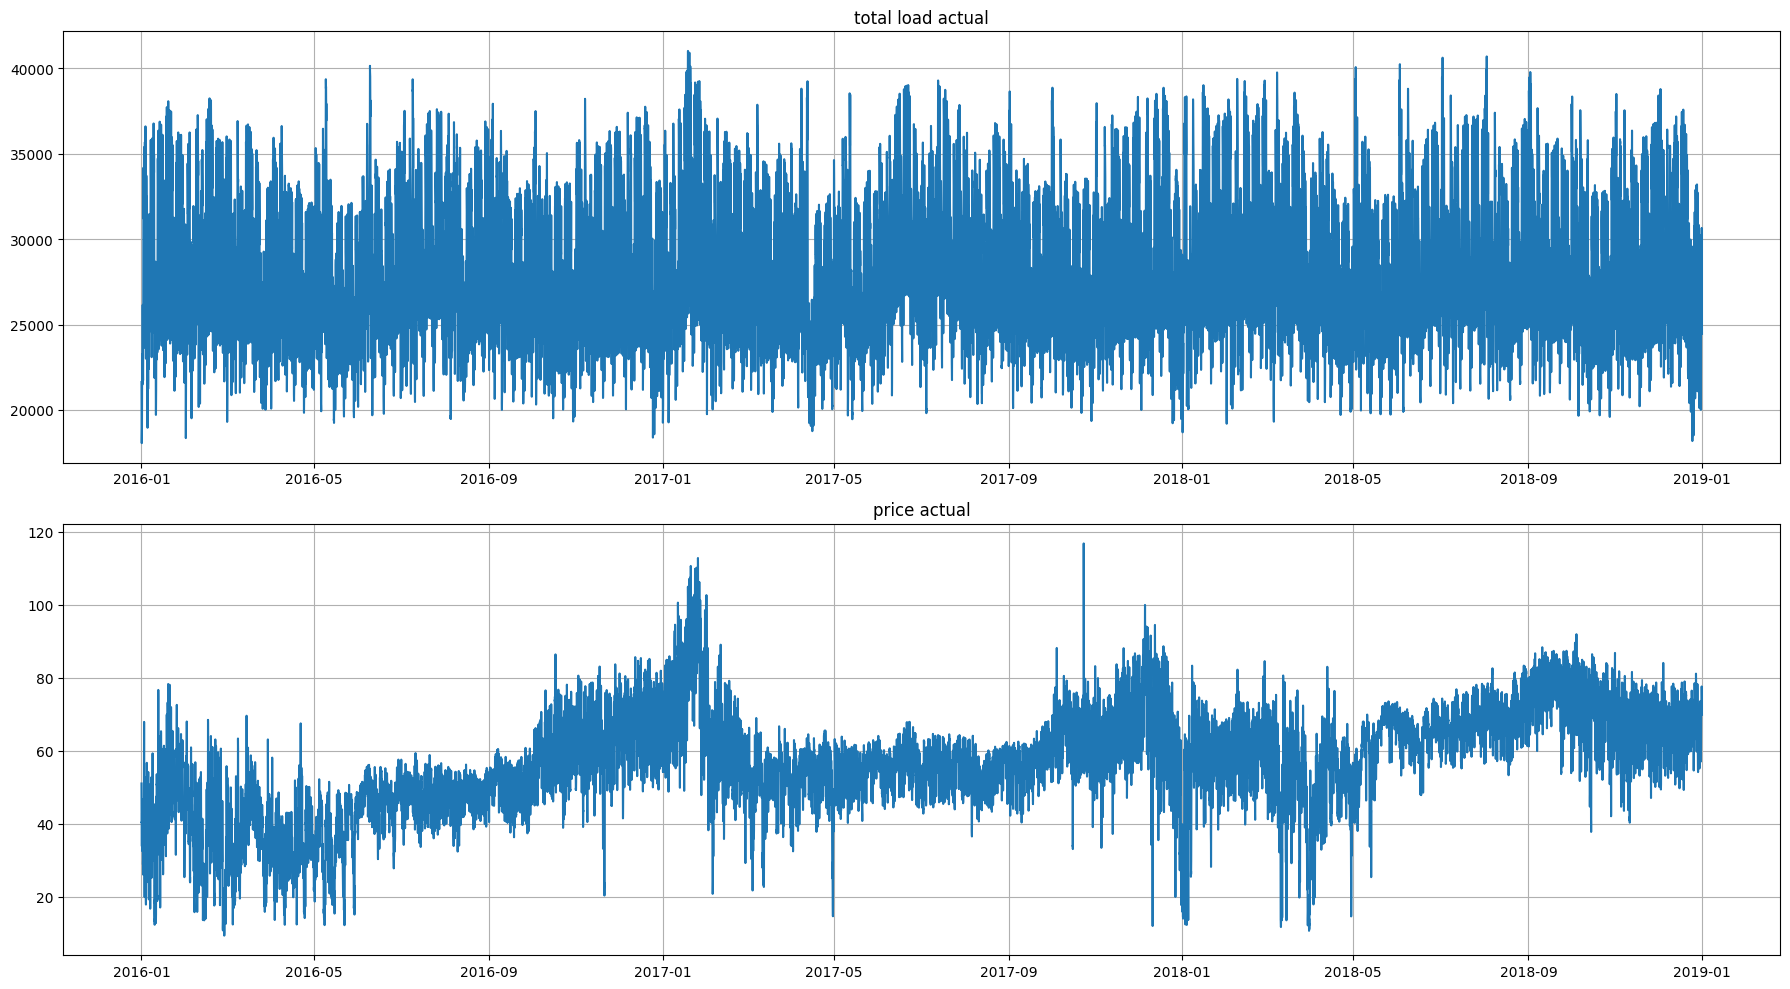

In [12]:
##Visualizing Data

fig, axs = plt.subplots(len(df.columns), 1, figsize=(18, 10)) # Changed the first argument to len(df.columns)

for i, col in enumerate(df.columns):
    axs[i].plot(df[col])
    axs[i].set_title(col)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

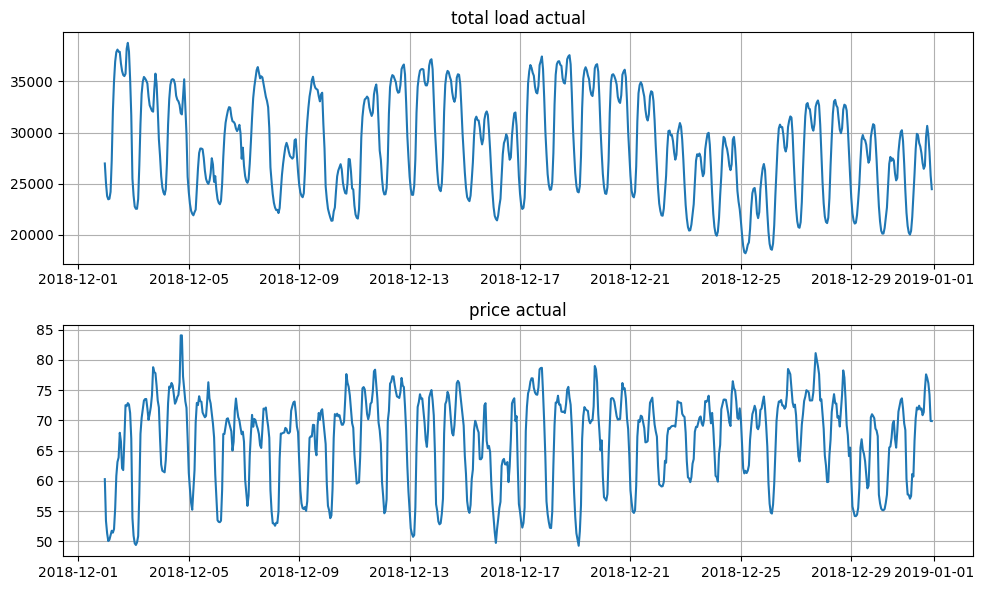

In [13]:
# Visualize the last few daya
fig, axs = plt.subplots(len(df.columns), 1, figsize=(10, 6))

for i, col in enumerate(df.columns):
    axs[i].plot(df[col][-24*30:])
    axs[i].set_title(col)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

There are clear seasonality, adding time features can high likely help models to capture these patterns.

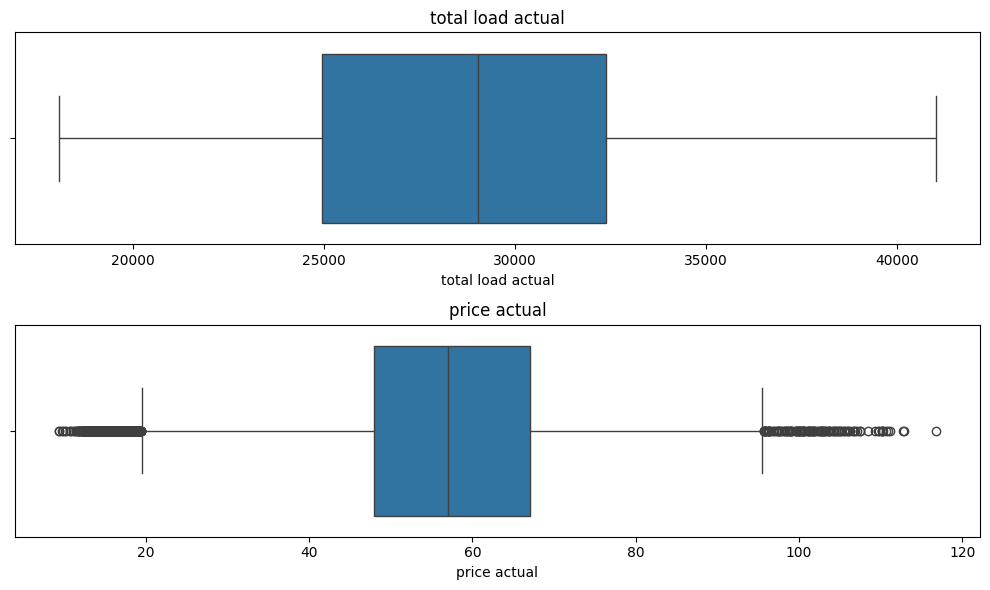

In [14]:
# Check outliers
fig, axs = plt.subplots(len(df.columns), 1, figsize=(10,6))

for i, col in enumerate(df.columns):
    sns.boxplot(x=df[col], ax=axs[i])
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

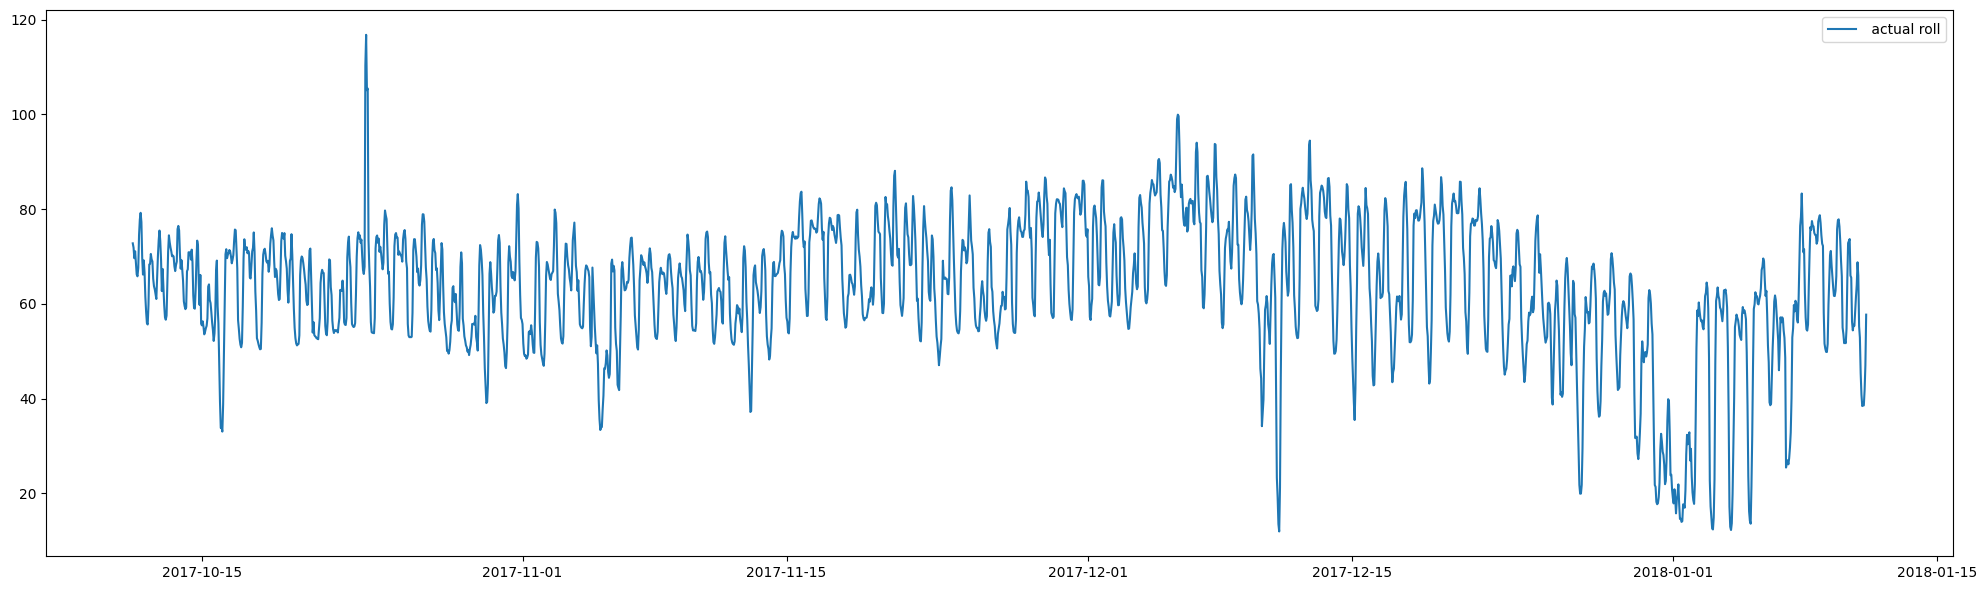

In [15]:
# Visualize the outliers
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(df[(df.index > '2017-10-11 07:00:00') & (df.index < '2018-01-11 07:00:00')]['price actual'], label=' actual roll')

plt.legend()
plt.tight_layout()
plt.show()

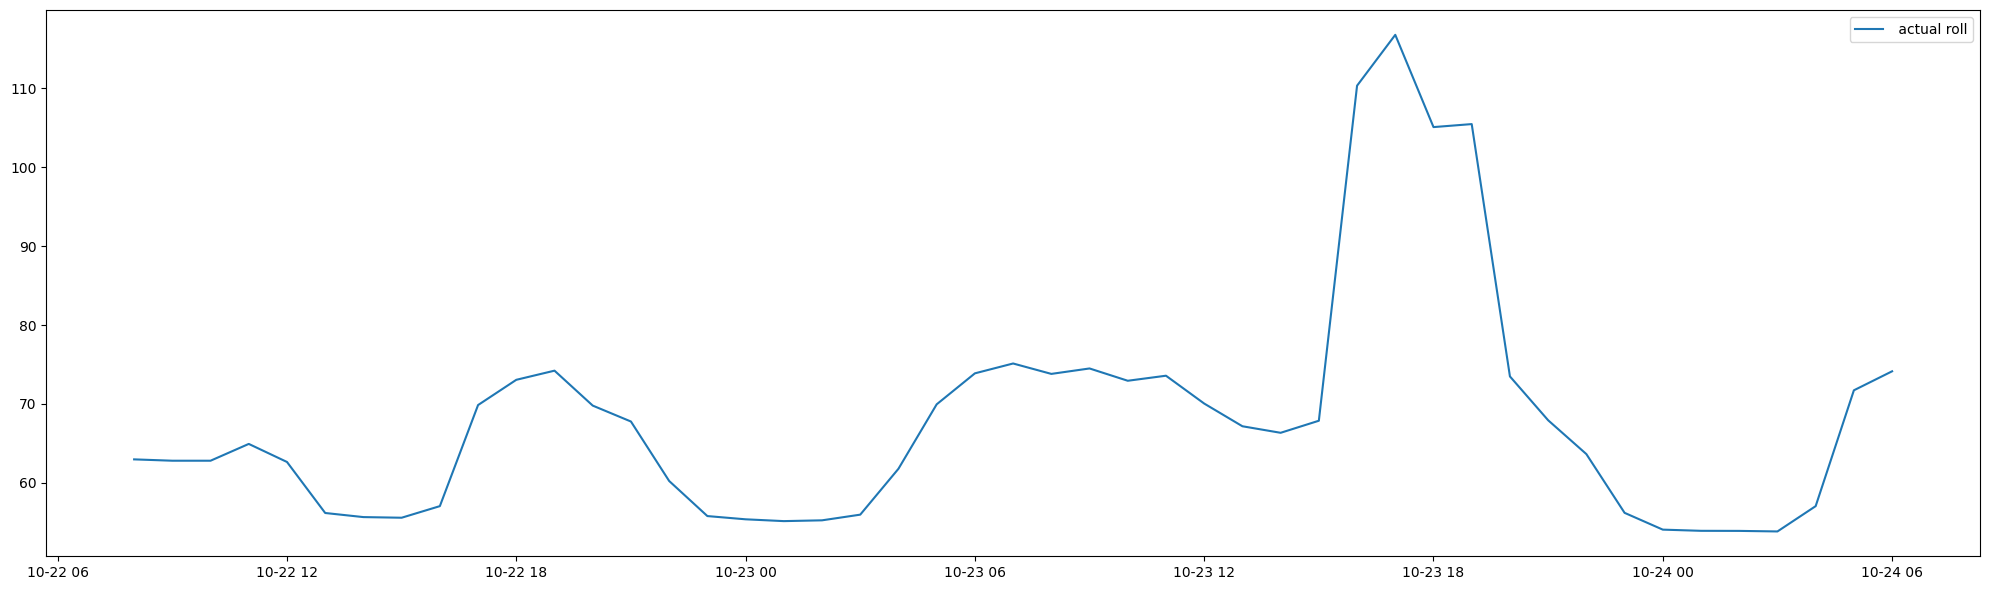

In [16]:
# Visualize the outliers
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(df[(df.index > '2017-10-22 07:00:00') & (df.index < '2017-10-24 07:00:00')]['price actual'], label=' actual roll')

plt.legend()
plt.tight_layout()
plt.show()

In [17]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total load actual,26303.0,28810.257138,4545.474497,18054.00,24932.50,29016.0,32371.00,41015.0
price actual,26303.0,56.726108,14.592461,9.33,47.99,57.0,67.02,116.8


The features are on different scales, so we need to apply scaling.

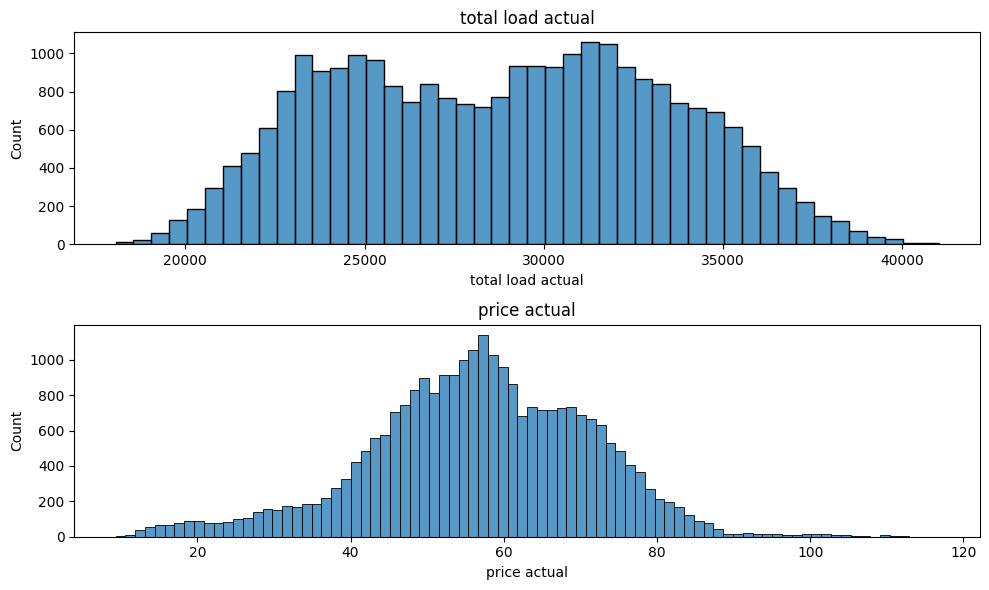

In [18]:
# Distribution
fig, axs = plt.subplots(len(df.columns), 1, figsize=(10,6))

for i, col in enumerate(df.columns):
    sns.histplot(x=df[col], ax=axs[i])
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

## 3-Feature Engineering

In [19]:
# Add some extra features

def add_time_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    return df

df = add_time_features(df)

In [20]:
# Correlation
df.corr() # The results show that 'hour' and 'dayofweek' are indeed higyly related to our desired targets.

,total load actual,price actual,hour,dayofweek
total load actual,1.000000,0.409105,0.394732,-0.196502
price actual,0.409105,1.000000,0.212474,-0.157526
hour,0.394732,0.212474,1.000000,0.000095
dayofweek,-0.196502,-0.157526,0.000095,1.000000


<Axes: xlabel='price actual rolling'>

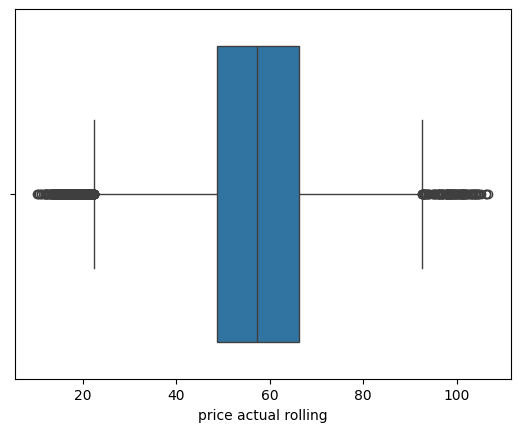

In [21]:
## Smooth features

original_cols = ['total load actual', 'price actual']
rolling_size = 8
for col in original_cols:
    df[f'{col} rolling'] = df[col].rolling(window=rolling_size).mean()
df.dropna(inplace=True)

# Use both the rolling mean values and the original values as input variables
rolling_columns = ['total load actual rolling', 'price actual rolling',]

# Plot a boxplot to visualize the distribution of the smoothed 'price actual rolling' feature
sns.boxplot(x=df['price actual rolling'])

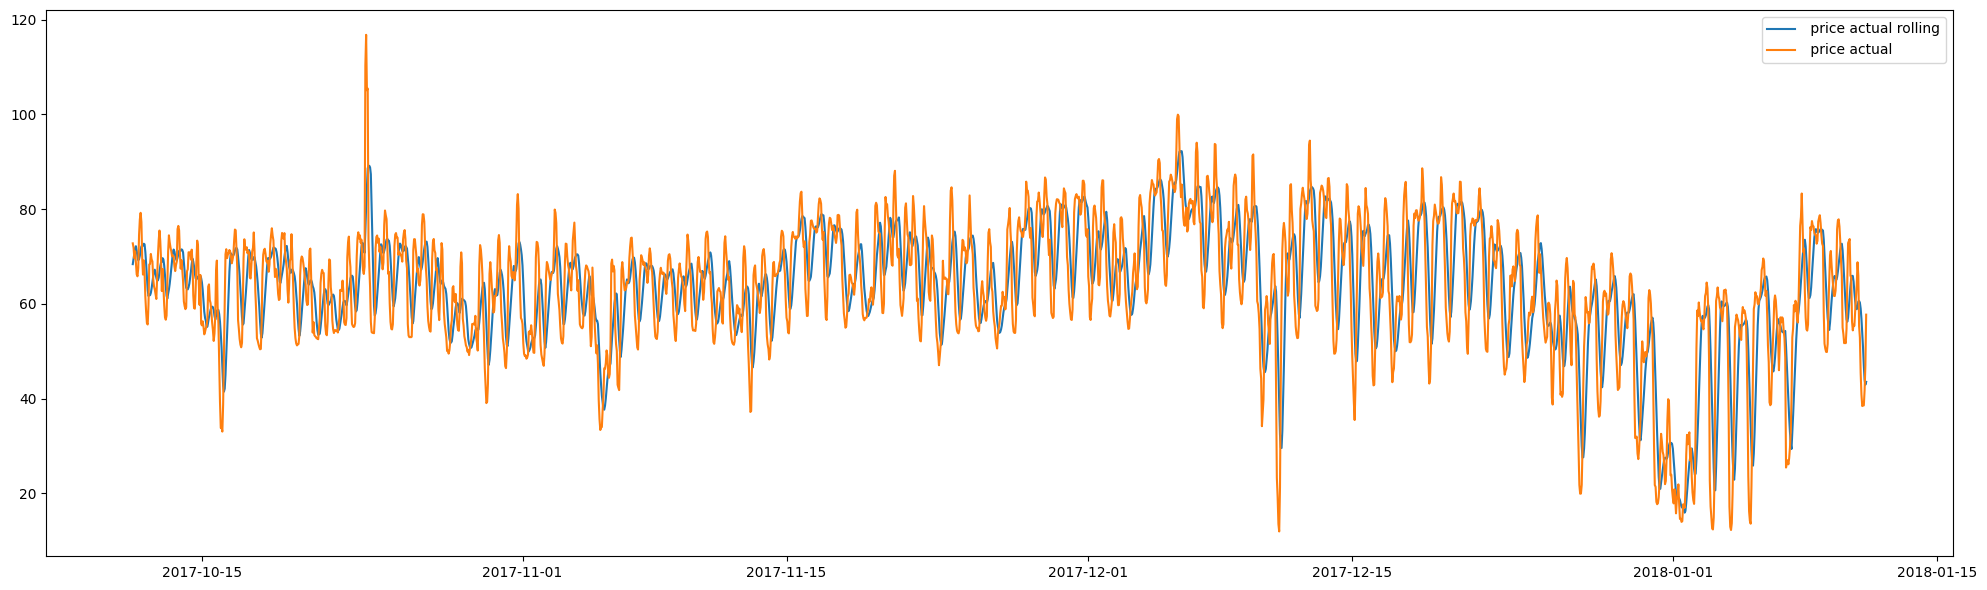

In [22]:
# Visualize part of the data again
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(df[(df.index > '2017-10-11 07:00:00') & (df.index < '2018-01-11 07:00:00')]['price actual rolling'], label=' price actual rolling')
ax.plot(df[(df.index > '2017-10-11 07:00:00') & (df.index < '2018-01-11 07:00:00')]['price actual'], label=' price actual')

plt.legend()
plt.tight_layout()
plt.show()

In [23]:
## Train Test Split
split_step = int(df.shape[0]*0.8)
train = df.iloc[:split_step].copy()
ver = df.iloc[split_step:].copy()
valid = ver.iloc[:int(ver.shape[0]*0.5)].copy()
test = ver.iloc[int(ver.shape[0]*0.5):].copy()

# For XGBoost
train_xgb, valid_xgb, test_xgb = train.copy(), valid.copy(), test.copy()

# For CNN-LSTM-DNN
## Scaling Function
# Initialize the scalers
rolling_scaler = MinMaxScaler()
load_scaler = MinMaxScaler()
price_scaler = MinMaxScaler()


for col in rolling_columns:
    train.loc[:,f'{col} scaled'] = rolling_scaler.fit_transform(train[[col]])
    valid.loc[:,f'{col} scaled'] = rolling_scaler.transform(valid[[col]])
    test.loc[:,f'{col} scaled'] = rolling_scaler.transform(test[[col]])

train.loc[:,'total load actual scaled'] = load_scaler.fit_transform(train[['total load actual']])
train.loc[:,'price actual scaled'] = price_scaler.fit_transform(train[['price actual']])
valid.loc[:,'total load actual scaled'] = load_scaler.transform(valid[['total load actual']])
valid.loc[:,'price actual scaled'] = price_scaler.transform(valid[['price actual']])
test.loc[:,'total load actual scaled'] = load_scaler.transform(test[['total load actual']])
test.loc[:,'price actual scaled'] = price_scaler.transform(test[['price actual']])



train.drop(['total load actual rolling', 'price actual rolling'], axis=1, inplace=True)
valid.drop(['total load actual rolling', 'price actual rolling'], axis=1, inplace=True)
test.drop(['total load actual rolling', 'price actual rolling'], axis=1, inplace=True)

# Final, we get the datasets ready for michine learning
train_s = train.drop(['total load actual', 'price actual'], axis=1)
valid_s = valid.drop(['total load actual', 'price actual'], axis=1)
test_s = test.drop(['total load actual', 'price actual'], axis=1)


In [24]:
train_s.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21036 entries, 2016-01-01 07:00:00 to 2018-05-26 18:00:00
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   hour                              21036 non-null  int32  
 1   dayofweek                         21036 non-null  int32  
 2   total load actual rolling scaled  21036 non-null  float64
 3   price actual rolling scaled       21036 non-null  float64
 4   total load actual scaled          21036 non-null  float64
 5   price actual scaled               21036 non-null  float64
dtypes: float64(4), int32(2)
memory usage: 986.1 KB


In [25]:
train_s = train_s.astype(np.float32)
valid_s = valid_s.astype(np.float32)
test_s = test_s.astype(np.float32)

In [26]:
train_s.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21036 entries, 2016-01-01 07:00:00 to 2018-05-26 18:00:00
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   hour                              21036 non-null  float32
 1   dayofweek                         21036 non-null  float32
 2   total load actual rolling scaled  21036 non-null  float32
 3   price actual rolling scaled       21036 non-null  float32
 4   total load actual scaled          21036 non-null  float32
 5   price actual scaled               21036 non-null  float32
dtypes: float32(6)
memory usage: 657.4 KB


In [ ]:
train_xgb.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21036 entries, 2016-01-01 07:00:00 to 2018-05-26 18:00:00
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   total load actual          21036 non-null  float64
 1   price actual               21036 non-null  float64
 2   hour                       21036 non-null  int32  
 3   dayofweek                  21036 non-null  int32  
 4   total load actual rolling  21036 non-null  float64
 5   price actual rolling       21036 non-null  float64
dtypes: float64(4), int32(2)
memory usage: 986.1 KB




```
window_size = 3

dataset = tf.data.Dataset.from_tensor_slices(train)
dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)

dataset = dataset.flat_map(lambda window: window.batch(window_size+1))

for window in dataset.take(1):
  print(window.numpy())
  print(f'shape: {window.numpy().shape}')

[[  0.482  247.138    0.       0.       0.       0.484 ]
 [  0.4824 247.212    0.       0.       0.       0.484 ]
 [  0.4824 247.364    0.       0.       0.       0.482 ]
 [  0.4828 247.564    0.       0.       0.       0.482 ]]
shape: (4, 6)

for window in dataset.take(1):
  print(window[:-1,:-1], window[-1][-1])

tf.Tensor(
[[  0.482  247.138    0.       0.       0.    ]
 [  0.4824 247.212    0.       0.       0.    ]
 [  0.4824 247.364    0.       0.       0.    ]], shape=(3, 5), dtype=float64) tf.Tensor(0.482, shape=(), dtype=float64)

# group into features and lables
dataset = dataset.map(lambda window: (window[:-1,:-1], window[-1][-1]))

for x, y in dataset.take(2):
  print('x = ', x.numpy())
  print('y = ', y.numpy())
  print()

x =  [[  0.482  247.138    0.       0.       0.    ]
 [  0.4824 247.212    0.       0.       0.    ]
 [  0.4824 247.364    0.       0.       0.    ]]
y =  0.482

x =  [[  0.4824 247.212    0.       0.       0.    ]
 [  0.4824 247.364    0.       0.       0.    ]
 [  0.4828 247.564    0.       0.       0.    ]]
y =  0.482
```



## 4-Model Building

### 4.1 Single Step + Autoregressive

In [ ]:
def single_step_windowed_dataset(series, window_size, batch_size, shuffle_buffer_size, input_columns, output_columns, column_names):
    """Generates dataset windows for single-step forecasting

    Args:
      series (array of float) - The time series data (can be multivariate).
      window_size (int) - Number of time steps in each input window.
      batch_size (int) - Number of samples per batch.
      shuffle_buffer_size (int) - Buffer size for shuffling the dataset.
      input_columns (list of str, or ints) - Column names or indices to be used as features.
      output_columns (str, or ints) - Column names or indices to be used as labels (target variables).
      column_names (list of str, optional) - List of column names in the input dataset.

    Returns:
      dataset (TF Dataset) - A TensorFlow dataset containing feature and label pairs.
    """

    # If column names are provided, map feature_columns and label_columns from names to indices
    if column_names is not None:
        input_columns = [column_names.index(col) if isinstance(col, str) else col for col in input_columns]
        output_columns = [column_names.index(col) if isinstance(col, str) else col for col in output_columns]
    else:
        # If no column names are provided, assume feature_columns and label_columns are indices
        raise ValueError(f"column_names are missing")

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data, ensuring each window has the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows into individual sequences
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Map each window to a tuple of (features, labels), where the label is the next time step
    dataset = dataset.map(lambda window: (tf.gather(window[:-1], input_columns, axis=-1),
                                          tf.gather(window[-1], output_columns, axis=-1))) # Here, -1 refers to single step method, we only forecast the next time step

    # Shuffle the dataset
    dataset = dataset.shuffle(shuffle_buffer_size)

    # Create batches and prefetch to optimize performance
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

def model_forecast(model, test_series, window_size, batch_size):
    """Generates predictions on test data windows using the provided model

    Args:
      model (TF Keras Model) - Trained model that accepts data windows.
      test_series (array of float) - The time series data to make predictions on.
      window_size (int) - Number of time steps in each input window.
      batch_size (int) - Number of samples per batch.

    Returns:
      forecast (numpy array) - Array of predictions made by the model.
    """

    # Create a TensorFlow dataset from the test time series
    dataset = tf.data.Dataset.from_tensor_slices(test_series)

    # Window the test data into sequences of the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows into individual sequences
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches and prefetch to optimize performance
    dataset = dataset.batch(batch_size).prefetch(1)

    # Use the model to predict the next time step for each window
    forecast = model.predict(dataset)

    return forecast

#### 4-1-1, Ss Single-Output (CNN_LSTM_DNN)


Initialize Parameters

In [ ]:
column_names = train_s.columns.to_list()
input_cols = train_s.columns.to_list()
window_size = 24 * 2
batch_size = 32
shuffle_buffer_size = 24*100 # this value depends on the size of the data, around the len(data) for small data and smaller len(data) for big data

Load Model

In [ ]:
# Load
output_cols = ['total load actual scaled']

def create_uncompiled_load_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', activation='relu',
                              input_shape=[window_size, len(input_cols)]),
        #tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=False),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(1),
    ])
    return model


def create_load_model(initial_lr=1e-1):

    # Set the initial learning rate
    initial_learning_rate=initial_lr

    # Define the scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=435,
        decay_rate=0.95,
        staircase=True)

    # Set the optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    model = create_uncompiled_load_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    return model


# datasets preparation
train_load_set = single_step_windowed_dataset(series=train_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)

validation_load_set = single_step_windowed_dataset(series=valid_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)

# Initilize Model
single_step_single_output_load_model = create_load_model(initial_lr=1e-1)

# Fitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=8, restore_best_weights=True)
history = single_step_single_output_load_model.fit(train_load_set, validation_data=validation_load_set, epochs=40, callbacks=[early_stopping])

81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


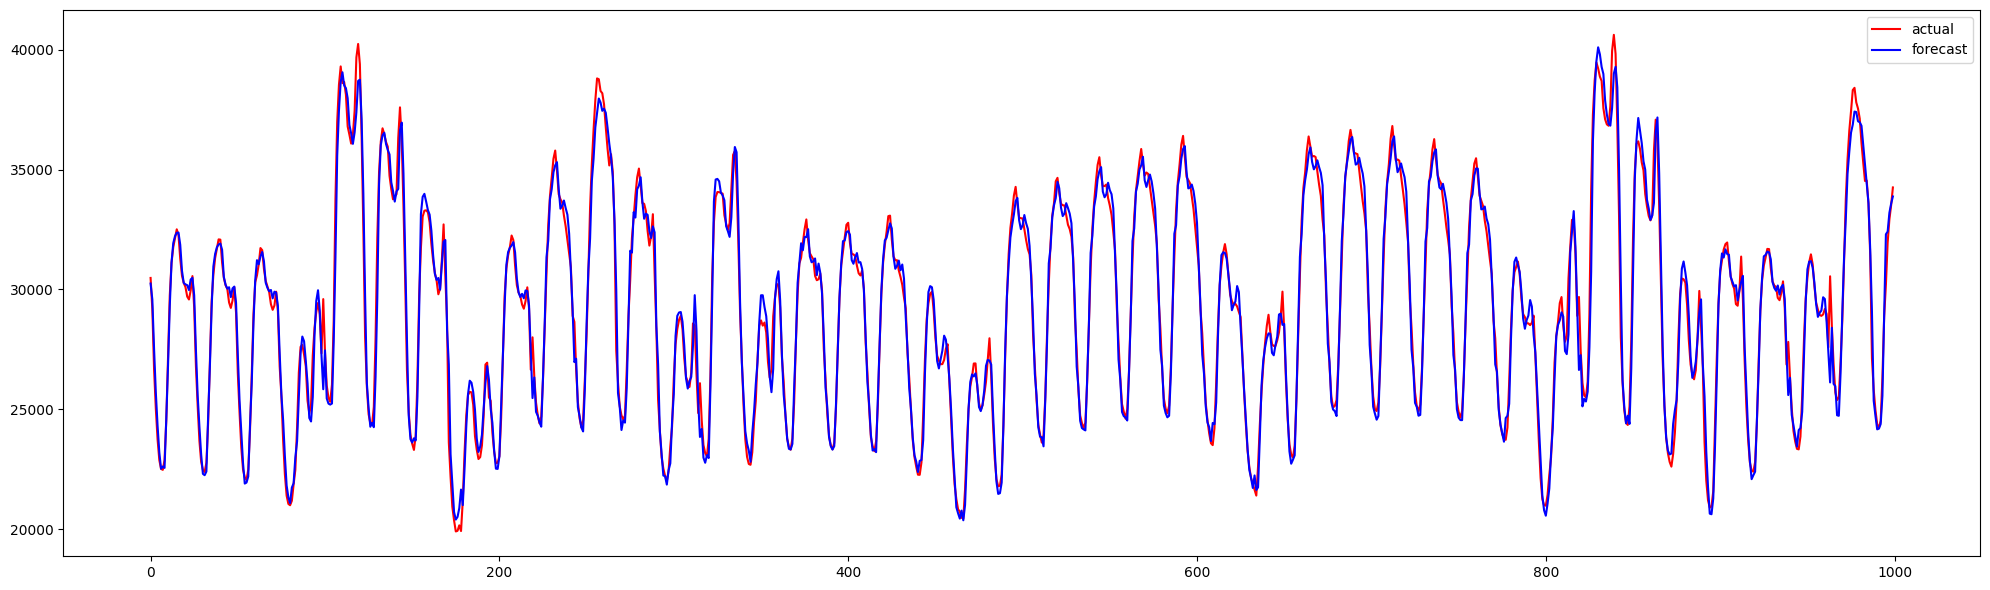

ss_load mse: 421287.0796235082
ss_load mae: 469.67368440162664


In [ ]:
single_step_single_output_load_model = load_model('single step single output load model.h5')

# Forecasting
load_prediction_scaled = model_forecast(single_step_single_output_load_model, valid_s, window_size, batch_size)


load_actual_scaled = valid_s.iloc[window_size:]['total load actual scaled'].to_list()

ss_load_scaled_mse = mean_squared_error(load_actual_scaled, load_prediction_scaled[:-1])
ss_load_scaled_mae = mean_absolute_error(load_actual_scaled, load_prediction_scaled[:-1])

# Use the load_scaler to inverse transform the predicted values
load_prediction_original = load_scaler.inverse_transform(load_prediction_scaled)

load_actual_original =  valid.iloc[window_size:]['total load actual'].to_list()

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(load_actual_original[:1000], c='red', label='actual')
ax.plot(load_prediction_original[:1000], c= 'blue', label='forecast')
plt.legend()
plt.tight_layout()
plt.show()


ss_load_mse = mean_squared_error(load_actual_original, load_prediction_original[:-1])
ss_load_mae = mean_absolute_error(load_actual_original, load_prediction_original[:-1])

print(f'ss_load mse: {ss_load_mse}')
print(f'ss_load mae: {ss_load_mae}')


Price Model

In [ ]:
output_cols = ['price actual scaled']
def create_uncompiled_price_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=4, strides=1, padding='causal', activation='relu',
                              input_shape=[window_size, len(input_cols)]),
        #tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32, return_sequences=False),
        #tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(1),
    ])
    return model


def create_price_model(initial_lr=1e-1):

    # Set the initial learning rate
    initial_learning_rate=initial_lr

    # Define the scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=400,
        decay_rate=0.8,
        staircase=True)

    # Set the optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    model = create_uncompiled_price_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    return model

train_price_set = single_step_windowed_dataset(series=train_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)

validation_price_set = single_step_windowed_dataset(series=valid_s,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)

single_step_single_output_price_model = create_price_model(initial_lr=1e-1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=8, restore_best_weights=True)


history = single_step_single_output_price_model.fit(train_price_set, validation_data=validation_price_set, epochs=20, callbacks=[early_stopping])

Epoch 1/20
    655/Unknown 25s 33ms/step - loss: 0.0086 - mae: 0.0931

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


656/656 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - loss: 0.0086 - mae: 0.0931 - val_loss: 0.0044 - val_mae: 0.0823
Epoch 2/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - loss: 0.0036 - mae: 0.0656 - val_loss: 7.0892e-04 - val_mae: 0.0297
Epoch 3/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - loss: 0.0018 - mae: 0.0467 - val_loss: 0.0013 - val_mae: 0.0432
Epoch 4/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - loss: 0.0011 - mae: 0.0368 - val_loss: 5.4386e-04 - val_mae: 0.0263
Epoch 5/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - loss: 9.9596e-04 - mae: 0.0341 - val_loss: 5.0255e-04 - val_mae: 0.0253
Epoch 6/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - loss: 8.6962e-04 - mae: 0.0319 - val_loss: 5.8264e-04 - val_mae: 0.0272
Epoch 7/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 39s 37ms/step - loss: 8.2151e-04 - mae: 0.0310 - val_loss: 0.0010 - val_mae: 0.0361
Epoch 8/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 7.7186e-04 - mae: 0.0298 - val_loss: 5.5877e-04 - val_mae: 0.0266
Epoch 9/20
656/

In [ ]:
single_step_single_output_price_model = load_model('single step single output price model.h5')

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


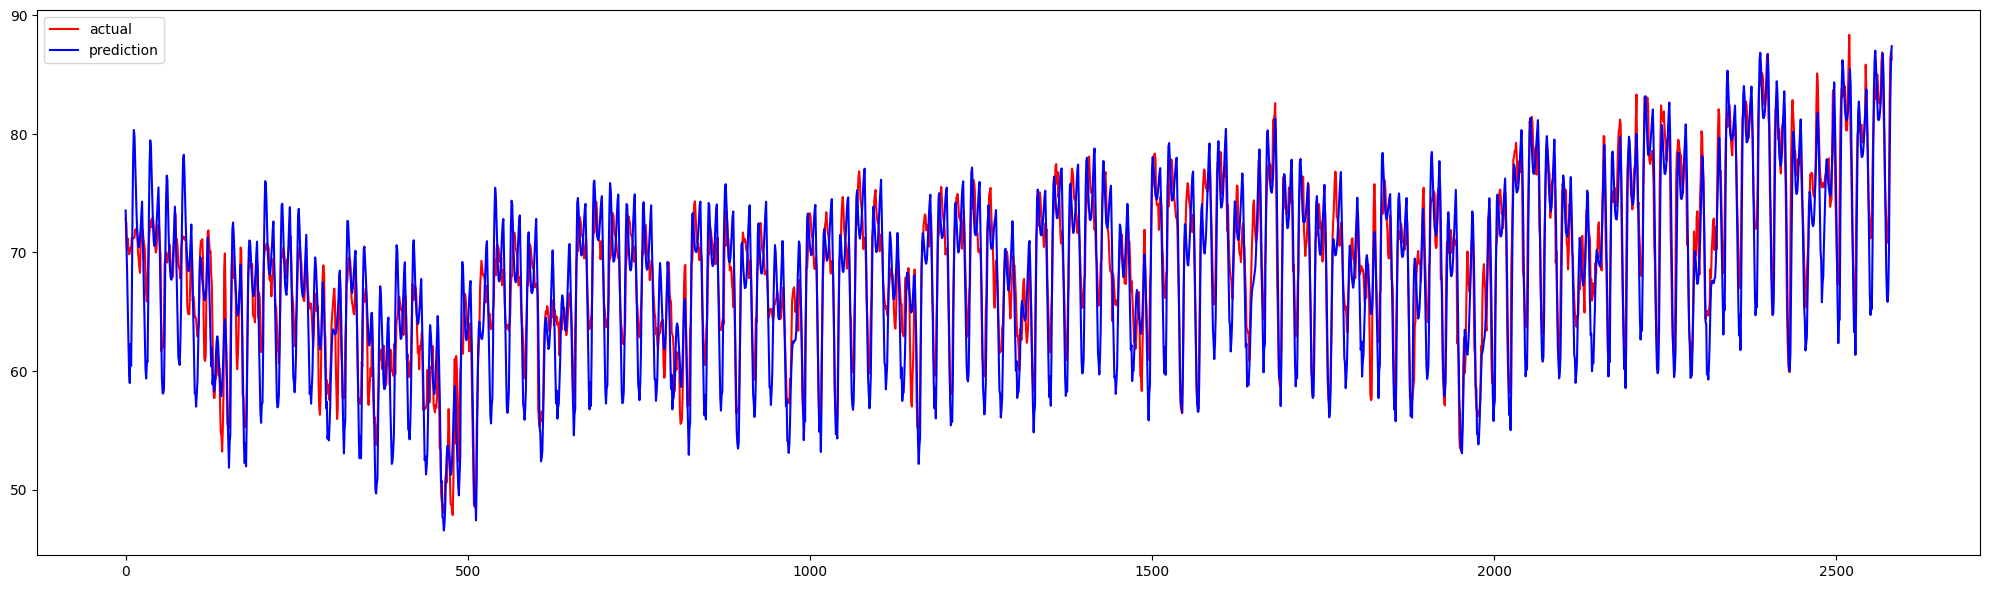

ss_price mse: 10.793887338955855
ss_price mae: 2.644858715373541


In [ ]:
single_step_single_output_price_model = load_model('single step single output price model.h5')

price_prediction_scaled = model_forecast(single_step_single_output_price_model, valid_s, window_size, batch_size)

price_actual_scaled = valid_s.iloc[window_size:]['price actual scaled'].to_list()

ss_price_scaled_mse = mean_squared_error(price_actual_scaled, price_prediction_scaled[:-1])
ss_price_scaled_mae = mean_absolute_error(price_actual_scaled, price_prediction_scaled[:-1])

# Use the price_scaler to inverse transform the predicted values
price_prediction_original = price_scaler.inverse_transform(price_prediction_scaled)

price_actual_original =  valid.iloc[window_size:]['price actual'].to_list()

ss_price_mse = mean_squared_error(price_actual_original, price_prediction_original[:-1])
ss_price_mae = mean_absolute_error(price_actual_original, price_prediction_original[:-1])


fig, ax = plt.subplots(figsize=(20,6))
ax.plot(price_actual_original[:], c='red', label='actual')
ax.plot(price_prediction_original[:-1], c= 'blue', label='prediction')
plt.legend()
plt.tight_layout()
plt.show()


print(f'ss_price mse: {ss_price_mse}')
print(f'ss_price mae: {ss_price_mae}')

#single_step_single_output_price_model.save('single step single output price model.h5')

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    656/Unknown 53s 71ms/step - loss: 0.0139 - mae: 0.1264

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


656/656 ━━━━━━━━━━━━━━━━━━━━ 59s 80ms/step - loss: 0.0139 - mae: 0.1264 - val_loss: 0.0072 - val_mae: 0.0896
Epoch 2/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 80s 78ms/step - loss: 0.0064 - mae: 0.0873 - val_loss: 0.0030 - val_mae: 0.0600
Epoch 3/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 82s 78ms/step - loss: 0.0032 - mae: 0.0617 - val_loss: 0.0021 - val_mae: 0.0509
Epoch 4/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 83s 79ms/step - loss: 0.0026 - mae: 0.0563 - val_loss: 0.0023 - val_mae: 0.0532
Epoch 5/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 52s 79ms/step - loss: 0.0022 - mae: 0.0521 - val_loss: 0.0021 - val_mae: 0.0506
Epoch 6/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 51s 76ms/step - loss: 0.0021 - mae: 0.0510 - val_loss: 0.0019 - val_mae: 0.0499
Epoch 7/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 48s 73ms/step - loss: 0.0018 - mae: 0.0469 - val_loss: 0.0021 - val_mae: 0.0510
Epoch 8/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 87s 81ms/step - loss: 0.0018 - mae: 0.0466 - val_loss: 0.0019 - val_mae: 0.0475
Epoch 9/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 78s 75ms/st

In [ ]:
# Retrain the trian_s + valid_s dataset
full_train = pd.concat([train_s, valid_s])

In [ ]:
column_names = train_s.columns.to_list()
input_cols = train_s.columns.to_list()
window_size = 24 * 2
batch_size = 32
shuffle_buffer_size = 24*200 # this value depends on the size of the data, around the len(data) for small data and smaller len(data) for big data

In [ ]:
output_cols = ['price actual scaled']
fulltrain_price_set = single_step_windowed_dataset(series=full_train,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer_size=shuffle_buffer_size,
                             input_columns=input_cols,
                             output_columns=output_cols,
                             column_names=column_names)

# Create a new instance of the price model (or use the existing model and recompile it)
single_step_single_output_price_model = create_price_model(initial_lr=1e-1)


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=8, restore_best_weights=True)
history = single_step_single_output_price_model.fit(fulltrain_price_set, epochs=17, callbacks=[early_stopping])

Epoch 1/17


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


739/739 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - loss: 0.0083 - mae: 0.0950
Epoch 2/17


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_mae` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


739/739 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - loss: 0.0039 - mae: 0.0677
Epoch 3/17
739/739 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - loss: 0.0014 - mae: 0.0406
Epoch 4/17
739/739 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - loss: 0.0011 - mae: 0.0363
Epoch 5/17
739/739 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.0010 - mae: 0.0341
Epoch 6/17
739/739 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - loss: 9.1021e-04 - mae: 0.0320
Epoch 7/17
739/739 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - loss: 8.8477e-04 - mae: 0.0314
Epoch 8/17
739/739 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - loss: 8.6208e-04 - mae: 0.0312
Epoch 9/17
739/739 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - loss: 8.4982e-04 - mae: 0.0309
Epoch 10/17
739/739 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - loss: 8.2146e-04 - mae: 0.0302
Epoch 11/17
739/739 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - loss: 8.0810e-04 - mae: 0.0299
Epoch 12/17
739/739 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - loss: 8.0200e-04 - mae: 0.0297
Epoch 13/17
739/739 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - loss: 8.00

Forecast

In [ ]:
test_s.shape

(2630, 6)

In [ ]:
test_s.columns

Index(['hour', 'dayofweek', 'total load actual rolling scaled',
       'price actual rolling scaled', 'total load actual scaled',
       'price actual scaled'],
      dtype='object')

In [ ]:
import multiprocessing
import numpy as np
from joblib import Parallel, delayed
import time

multiprocessing.set_start_method('forkserver', force=True)


def forecast_single_window(last_step, test_data, model_load, model_price, forecast_size, window_size, rolling_size):
    # Extract the last window of data for this forecast
    last_rows = test_data[last_step - window_size:last_step]
    input_data = last_rows.values.reshape(1, window_size, last_rows.shape[1])

    # Initialize rolling buffers as NumPy arrays
    roll_load_buffer = np.array(last_rows['total load actual scaled'].values[-rolling_size :])  # Using column index 2
    roll_price_buffer = np.array(last_rows['price actual scaled'].values[-rolling_size:])  # Using column index 3

    # Initialize the current time based on the last row of last_rows
    current_time = last_rows.index[-1]  # Assuming the index of test_data contains the timestamp

    forecast_steps = []

    for _ in range(forecast_size):
        # Predict the next load and price
        next_load = model_load.predict(input_data)
        next_price = model_price.predict(input_data)

        # Collect predictions
        forecast_steps.append((next_load[0][0], next_price[0][0]))

        # Updata buffers
        roll_load_buffer[:-1] = roll_load_buffer[1:]
        roll_load_buffer[-1] = next_load[0][0]

        roll_price_buffer[:-1] = roll_price_buffer[1:]
        roll_price_buffer[-1] = next_price[0][0]

        # Calculate new rolling scaled values
        total_load_roll_scaled = np.mean(roll_load_buffer)
        price_roll_scaled = np.mean(roll_price_buffer)

        # Update time for next prediction
        current_time += pd.Timedelta(hours=1)  # Increment the current time by 1 hour
        new_hour = current_time.hour
        new_dayofweek = current_time.dayofweek

        # Prepare next input
        next_input = np.array([[new_hour, new_dayofweek, total_load_roll_scaled, price_roll_scaled,
                                next_load[0][0], next_price[0][0]]])
        input_data = np.append(input_data[:, 1:, :], [next_input], axis=1)

    return forecast_steps

# Example usage:

forecast_size = 24  # Forecasting the next 24 hours
window_size = 48  # Using the last 48 hours for the input window
rolling_size = 3  # Keeping a rolling buffer of the last 3 values
test_data = test_s[:window_size+forecast_size+24]  # Adjusting test data size

start_time = time.time()
# Parallelize the forecast
predictions = Parallel(n_jobs=-1)(delayed(forecast_single_window)(last_step, test_data, single_step_single_output_load_model,
                                                                  single_step_single_output_price_model, forecast_size,
                                                                  window_size, rolling_size)
                                  for last_step in range(window_size, len(test_data) - forecast_size))
predictions = np.array(predictions)

end_time = time.time()
print(f"Total running time: {end_time - start_time} seconds")

Total running time: 122.27068495750427 seconds


In [ ]:
predictions.shape

(24, 24, 2)

In [ ]:
def generate_actual_values(test_data, window_size, forecast_size):
    actual_values = []

    for last_step in range(window_size, len(test_data) - forecast_size):
        # Extract actual load and price values for the forecast period
        actual_load = test_data.iloc[last_step:last_step + forecast_size]['total load actual scaled'].values
        actual_price = test_data.iloc[last_step:last_step + forecast_size]['price actual scaled'].values

        # Combine load and price into a single array with shape (forecast_size, 2)
        combined_actual = np.column_stack((actual_load, actual_price))

        # Append to the list
        actual_values.append(combined_actual)

    # Convert the list of arrays to a NumPy array with shape (number_of_windows, forecast_size, 2)
    actual_values = np.array(actual_values)

    return actual_values

actual_values = generate_actual_values(test_data, window_size, forecast_size)

In [ ]:
# Extract predicted and actual load and price
predicted_load = predictions[:, :, 0]  # Load is at index 0
predicted_price = predictions[:, :, 1]  # Price is at index 1

actual_load = actual_values[:, :, 0]  # Load is at index 0
actual_price = actual_values[:, :, 1]  # Price is at index 1

# Flatten the arrays to compute overall error metrics
mse_load = mean_squared_error(actual_load.flatten(), predicted_load.flatten())
mae_load = mean_absolute_error(actual_load.flatten(), predicted_load.flatten())

mse_price = mean_squared_error(actual_price.flatten(), predicted_price.flatten())
mae_price = mean_absolute_error(actual_price.flatten(), predicted_price.flatten())

print(f"Load - MSE: {mse_load}, MAE: {mae_load}")
print(f"Price - MSE: {mse_price}, MAE: {mae_price}")

Load - MSE: 0.03718778118491173, MAE: 0.15469057857990265
Price - MSE: 0.01935565657913685, MAE: 0.12134633958339691


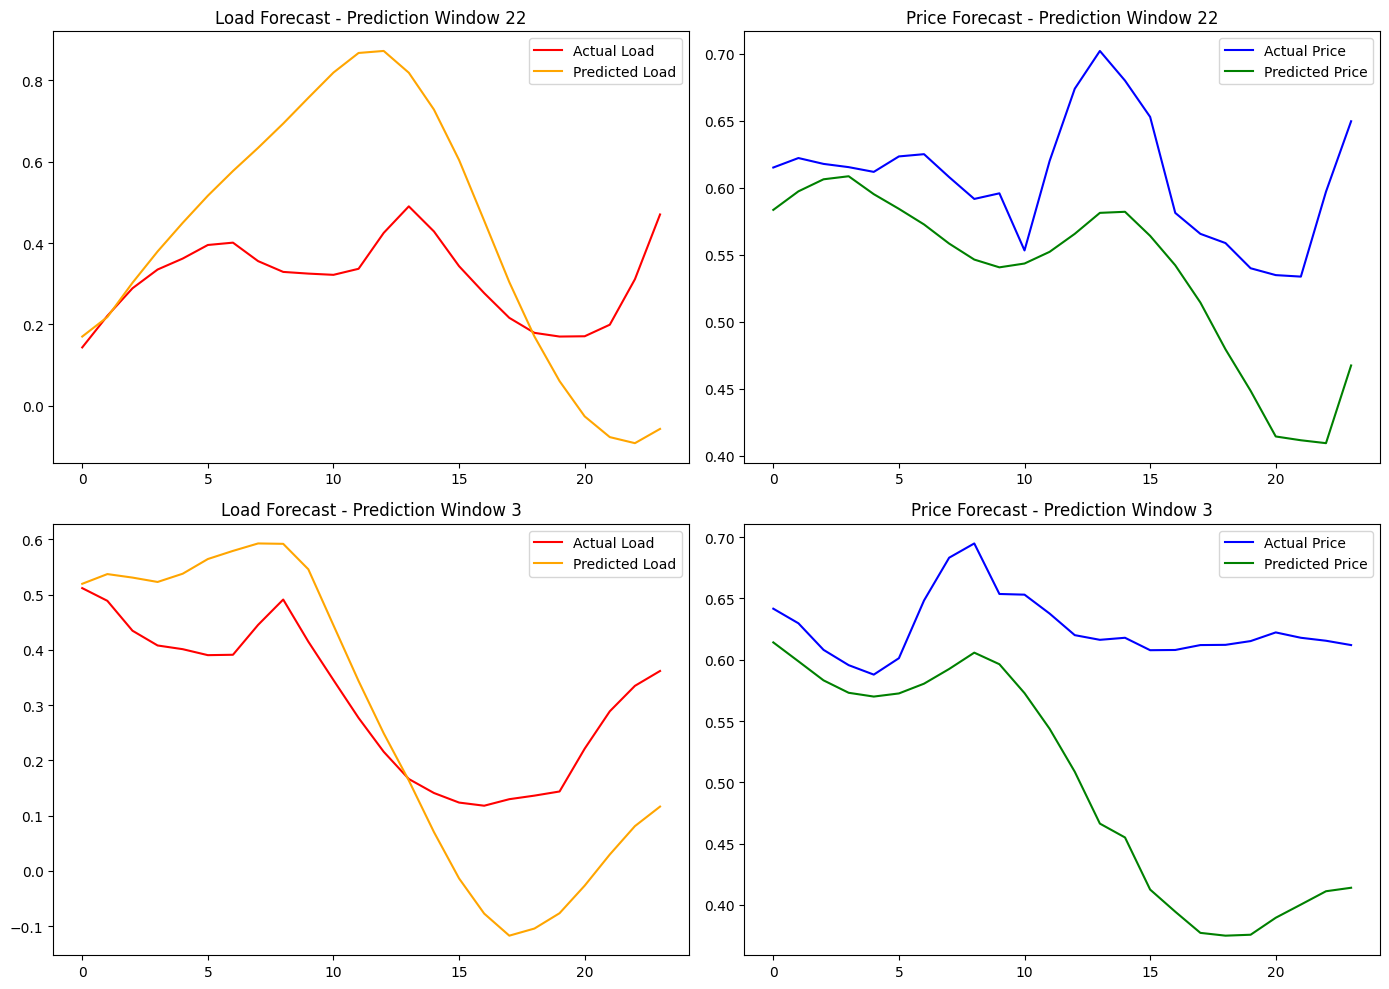

In [ ]:
# Randomly choose two different prediction windows
random_windows = np.random.choice(predictions.shape[0], size=2, replace=False)
# Plot predictions vs actual values for the randomly selected windows
plt.figure(figsize=(14, 10))

for i, window in enumerate(random_windows):
    plt.subplot(2, 2, i * 2 + 1)
    plt.plot(actual_load[window], label='Actual Load', color='red')
    plt.plot(predicted_load[window], label='Predicted Load', color='orange')
    plt.title(f'Load Forecast - Prediction Window {window + 1}')
    plt.legend()

    plt.subplot(2, 2, i * 2 + 2)
    plt.plot(actual_price[window], label='Actual Price', color='blue')
    plt.plot(predicted_price[window], label='Predicted Price', color='green')
    plt.title(f'Price Forecast - Prediction Window {window + 1}')
    plt.legend()

plt.tight_layout()
plt.show()


#### 4-1-2, Ss Multi-Output (CNN_LSTM_DNN)

In [ ]:
output_cols = ['total load actual scaled', 'price actual scaled'] # predict multiple labels simultaneously

input_cols = column_names
column_names = train_s.columns.to_list()
window_size = 24 * 2
batch_size = 32
shuffle_buffer_size = 24*100 # this value depends on the size of the data, around the len(data) for small data and smaller len(data) for big data

train_set = single_step_windowed_dataset(
      series=train_s,
      window_size=window_size,
      batch_size=batch_size,
      shuffle_buffer_size=shuffle_buffer_size,
      input_columns=input_cols,
      output_columns=output_cols,
      column_names=column_names)

validation_set = single_step_windowed_dataset(
      series=valid_s,
      window_size=window_size,
      batch_size=batch_size,
      shuffle_buffer_size=shuffle_buffer_size,
      input_columns=input_cols,
      output_columns=output_cols,
      column_names=column_names)

# Build CNN-LSTM-DNN Model
def create_uncompiled_sm_model():
# Build CNN-LSTM-DNN Model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', activation='relu',
                              input_shape=[window_size, len(input_cols)]),
        #tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=False),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(2),
    ])
    return model

def create_sm_model(initial_lr=1e-1):

    # Set the initial learning rate
    initial_learning_rate=initial_lr

    # Define the scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=656,
        decay_rate=0.95,
        staircase=True)

    # Set the optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    model = create_uncompiled_sm_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    return model

single_step_multi_output_model = create_sm_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=8, restore_best_weights=True)



history = single_step_multi_output_model.fit(train_set, validation_data=validation_set, epochs=40, callbacks=[early_stopping])

Epoch 1/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 91s 77ms/step - loss: 0.0105 - mae: 0.1078 - val_loss: 0.0070 - val_mae: 0.0974
Epoch 2/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 80s 74ms/step - loss: 0.0056 - mae: 0.0819 - val_loss: 0.0035 - val_mae: 0.0664
Epoch 3/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 84s 77ms/step - loss: 0.0040 - mae: 0.0693 - val_loss: 0.0030 - val_mae: 0.0613
Epoch 4/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 49s 74ms/step - loss: 0.0030 - mae: 0.0599 - val_loss: 0.0025 - val_mae: 0.0541
Epoch 5/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 85s 78ms/step - loss: 0.0023 - mae: 0.0521 - val_loss: 0.0025 - val_mae: 0.0531
Epoch 6/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 52s 79ms/step - loss: 0.0021 - mae: 0.0493 - val_loss: 0.0020 - val_mae: 0.0488
Epoch 7/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 80s 75ms/step - loss: 0.0019 - mae: 0.0469 - val_loss: 0.0020 - val_mae: 0.0474
Epoch 8/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 80s 73ms/step - loss: 0.0017 - mae: 0.0451 - val_loss: 0.0015 - val_mae: 0.0418
Epoch 9/40
656/656 ━━━━━━━━━━━━━━━━━━━━ 

81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


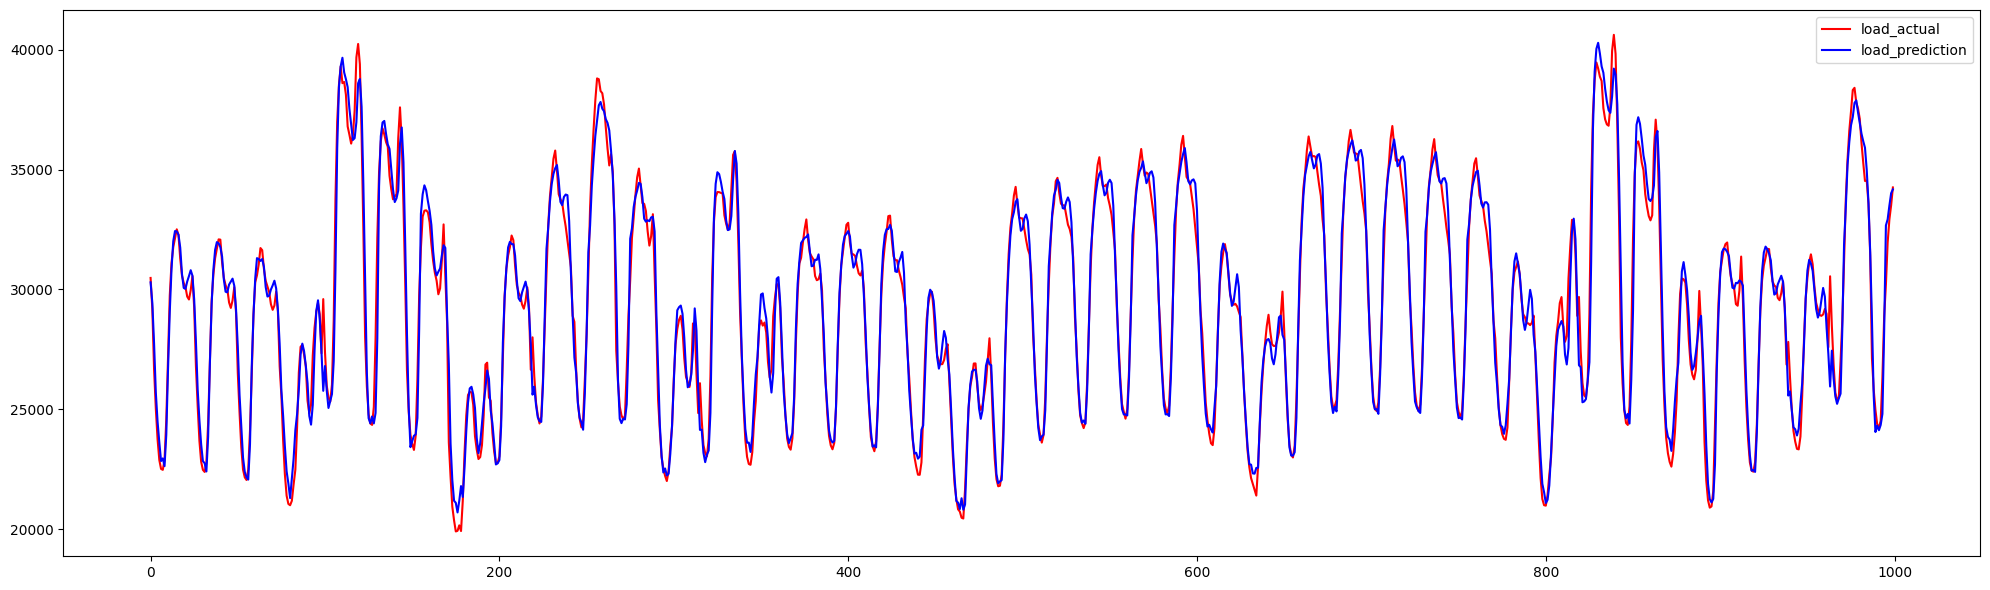

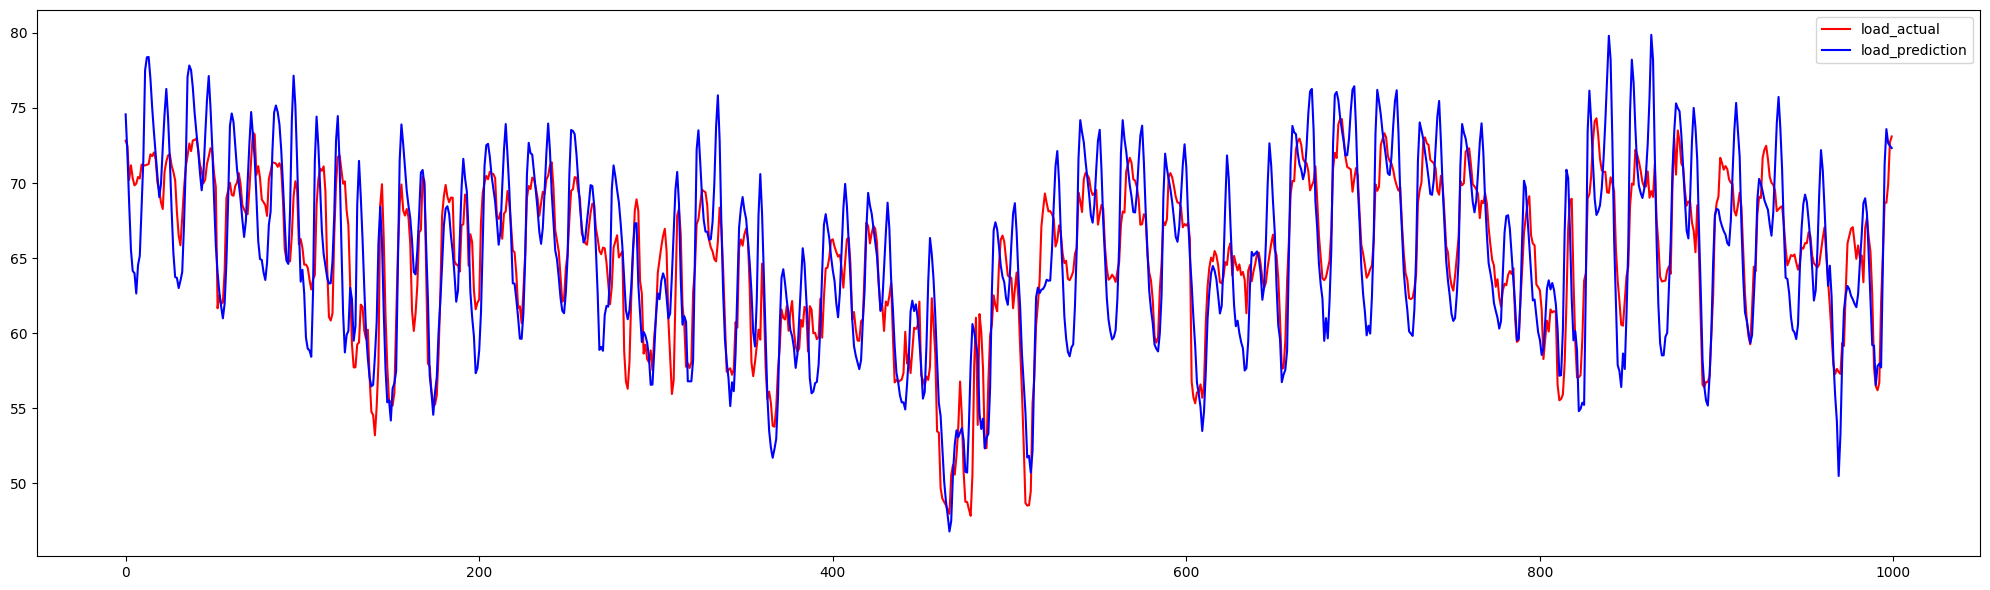

sm_load_mse: 645594.9917086934
sm_load_mae: 580.249161109363
sm_price_mse: 11.138330761564935
sm_price_mae: 2.620886313086051


In [ ]:
single_step_multi_output_model = load_model('single_step_multi_output_model.h5')

forecast = model_forecast(model=single_step_multi_output_model, test_series=valid_s, window_size=window_size, batch_size=batch_size)

load_prediction_scaled = forecast[:-1,0].copy()
price_prediction_scaled = forecast[:-1,1].copy()

load_actual_scaled = valid_s['total load actual scaled'][window_size:].to_list()
price_actual_scaled = valid_s['price actual scaled'][window_size:].to_list()



load_prediction_original = load_scaler.inverse_transform(forecast[:-1,0].reshape(-1,1))
price_prediction_original = price_scaler.inverse_transform(forecast[:-1,1].reshape(-1,1))

load_actual_original = valid.iloc[window_size:]['total load actual'].to_list()
price_actual_original = valid.iloc[window_size:]['price actual'].to_list()

sm_load_mse = mean_squared_error(load_actual_original, load_prediction_original)
sm_load_mae = mean_absolute_error(load_actual_original, load_prediction_original)

sm_price_mse = mean_squared_error(price_actual_original, price_prediction_original)
sm_price_mae = mean_absolute_error(price_actual_original, price_prediction_original)



fig, ax = plt.subplots(figsize=(20,6))
ax.plot(load_actual_original[:1000], c='red', label='load_actual')
ax.plot(load_prediction_original[:1000], c= 'blue', label='load_prediction')
plt.legend()
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(20,6))
ax.plot(price_actual_original[:1000], c='red', label='load_actual')
ax.plot(price_prediction_original[:1000], c= 'blue', label='load_prediction')
plt.legend()
plt.tight_layout()
plt.show()


print(f'sm_load_mse: {sm_load_mse}')
print(f'sm_load_mae: {sm_load_mae}')

print(f'sm_price_mse: {sm_price_mse}')
print(f'sm_price_mae: {sm_price_mae}')
# single_step_multi_output_model.save('single_step_multi_output_model.h5')

Based on the above results, one can see that single step signle output model performs better.

In [ ]:
# Forecast
forecast_size=24

last_rows = valid_s[:48].copy()

input_columns = ['total load actual_roll_scaled', 'price actual_roll_scaled']
last_data = last_rows[input_columns].values

# Reshape last_data to match the model's expected input shape (batch_size, time_steps, features)
input_data = last_data.reshape(1, window_size, len(input_columns))


# Initialize buffers to store the last two predicted values for rolling calculations
rolling_window = 3
roll_load_buffer = list(last_rows['total load actual scaled'].values[-rolling_window+1:])
roll_price_buffer = list(last_rows['price actual scaled'].values[-rolling_window+1:])

# Initialize an empty list to store the predictions
predictions = []


# Recursively predict the next 24 hours
for _ in range(forecast_size):
    # Predict the next time step
    next_values = single_step_single_output_model.predict(input_data)

    # Store the prediction
    predictions.append((next_values[0][0], next_values[0][1]))

    # Update the buffers with the new prediction (simulating the new actual values)
    roll_load_buffer.append(next_values[0][0])
    roll_price_buffer.append(next_values[0][1])

    # Keep only the last three values in the buffer
    if len(roll_load_buffer) > 3:
        roll_load_buffer.pop(0)
    if len(roll_price_buffer) > 3:
        roll_price_buffer.pop(0)

    # Calculate the new rolling scaled values
    total_load_roll_scaled = np.mean(roll_load_buffer)
    price_roll_scaled = np.mean(roll_price_buffer)

    # Update the input data with the new rolling scaled values
    next_input = np.array([[total_load_roll_scaled, price_roll_scaled]])
    input_data = np.append(input_data[:, 1:, :], [next_input], axis=1)

# Convert predictions to a NumPy array for easier manipulation
predictions = np.array(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


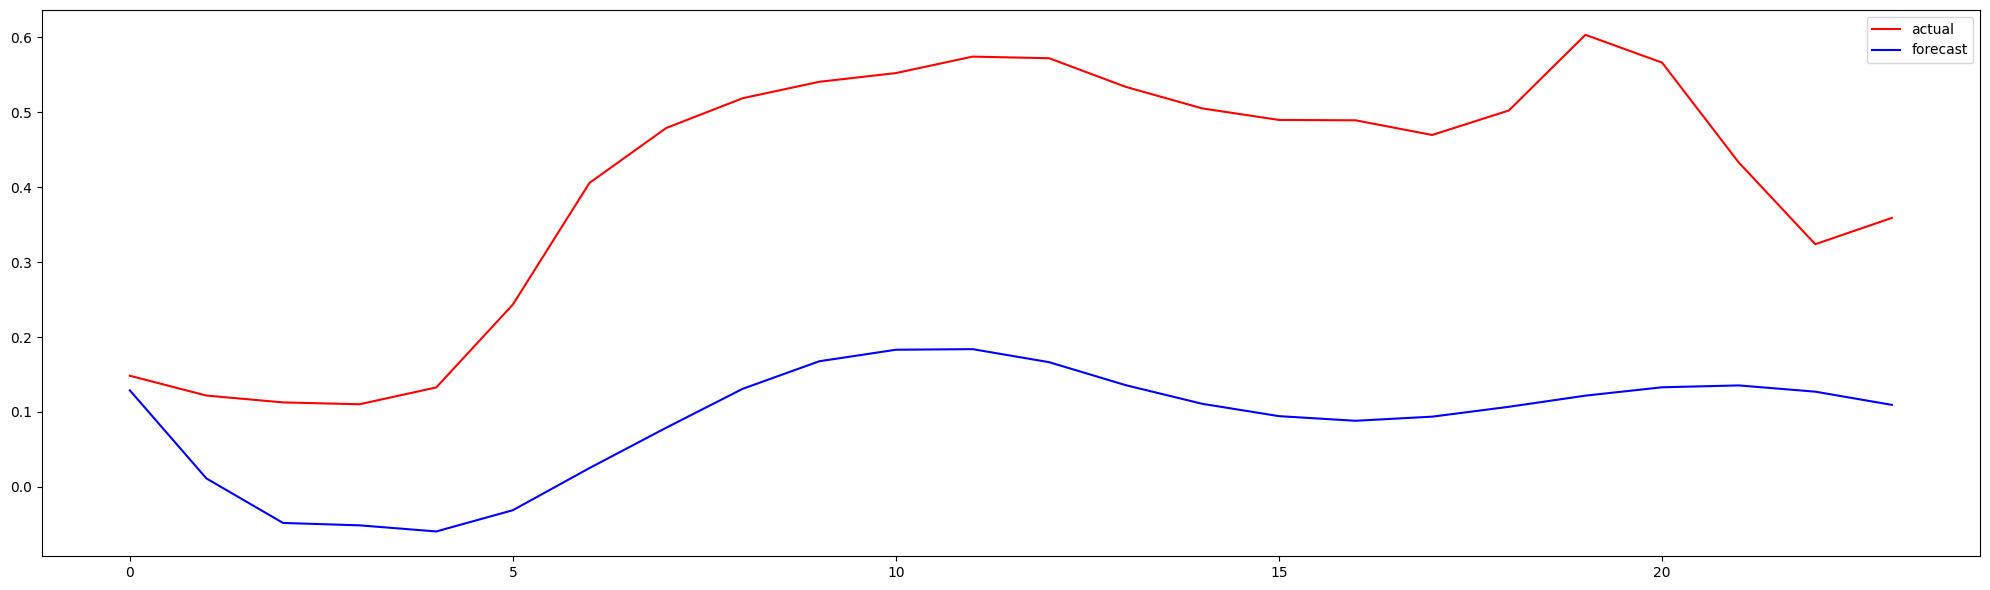

In [ ]:
output_cols=['total load actual scaled', 'price actual scaled']

actual = valid_s.iloc[48:72]['total load actual scaled'].to_list()

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(actual, c='red', label='actual')
ax.plot(predictions[:,0], c= 'blue', label='forecast')
plt.legend()
plt.tight_layout()
plt.show()


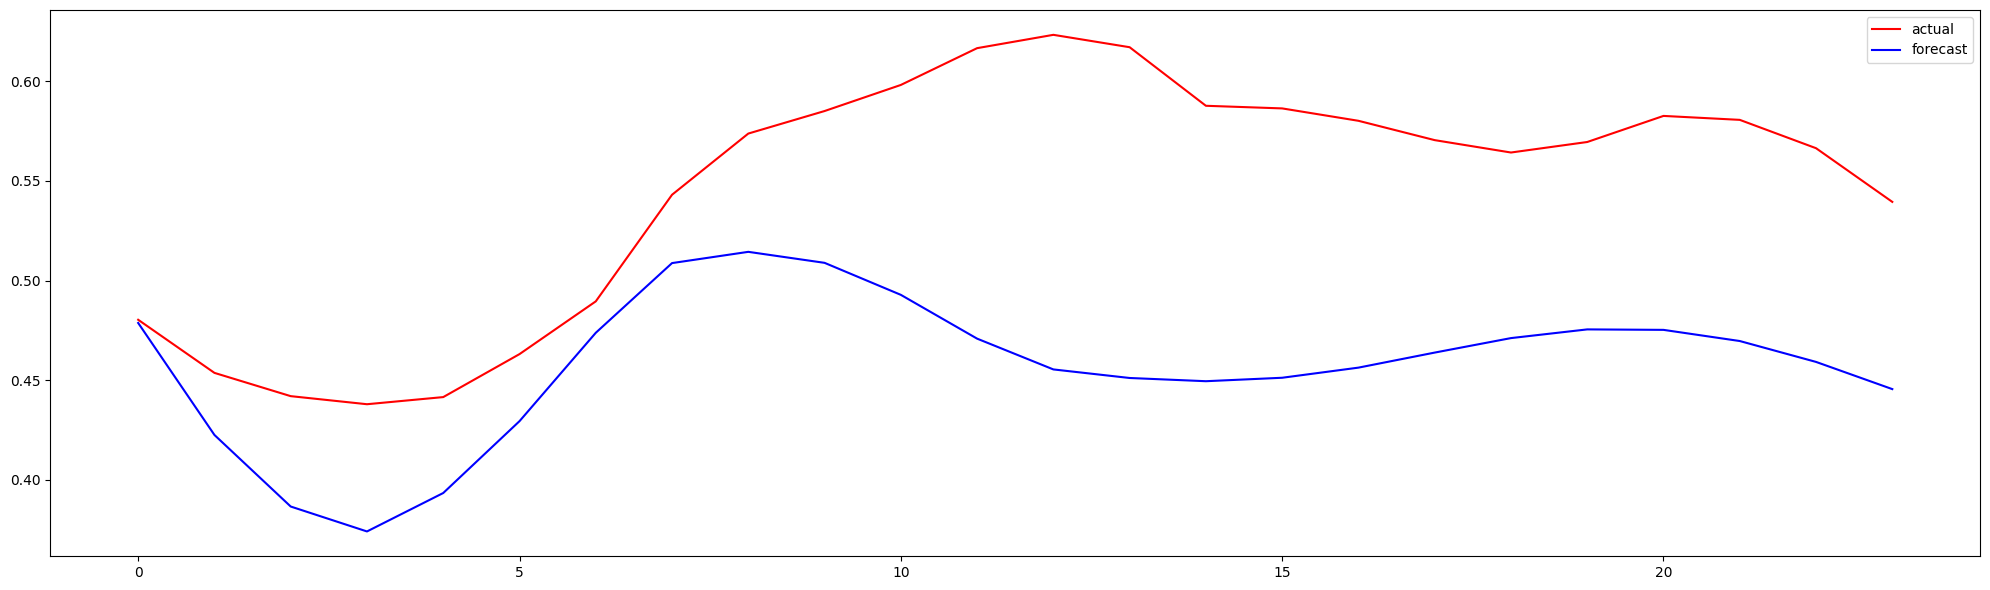

In [ ]:
output_cols=['total load actual scaled', 'price actual scaled']

actual = valid_s.iloc[48:72]['price actual scaled'].to_list()

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(actual, c='red', label='actual')
ax.plot(predictions[:,1], c= 'blue', label='forecast')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
zz = single_step_single_output_model.predict(input_data)
zz.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(1, 2)

#### 4-1-3, Ss Single Output (XGBoost)

Feature Engineering

In [ ]:
# Function to add lagged features
def add_lagged_features(df, lags=48):
    # Initialize dictionary to store lagged features
    lagged_features = {}

    # Add lagged features for 'total load actual' and 'price actual'
    for lag in range(1, lags):
        lagged_features[f'total load actual lag_{lag}'] = df['total load actual'].shift(lag)
        lagged_features[f'price actual lag_{lag}'] = df['price actual'].shift(lag)
        lagged_features[f'total load actual rolling lag_{lag}'] = df['total load actual rolling'].shift(lag)
        lagged_features[f'price actual rolling lag_{lag}'] = df['price actual rolling'].shift(lag)


    # Use pd.concat to add all the lagged features at once
    df = pd.concat([df, pd.DataFrame(lagged_features, index=df.index)], axis=1)

    # Dropping NaN values resulting from shifting operation
    df.dropna(inplace=True)

    return df


# Add lagged features
train_lagged = add_lagged_features(train_xgb, lags=48)
valid_lagged = add_lagged_features(valid_xgb, lags=48)
test_lagged = add_lagged_features(test_xgb, lags=48)

train_x = train_lagged.drop(['total load actual', 'price actual'], axis=1)
train_load = train_lagged['total load actual']
train_price = train_lagged['price actual']

valid_x = valid_lagged.drop(['total load actual', 'price actual'], axis=1)
valid_load = valid_lagged['total load actual']
valid_price = valid_lagged['price actual']

test_x = test_lagged.drop(['total load actual', 'price actual'], axis=1)
test_load = test_lagged['total load actual']
test_price = test_lagged['price actual']


Load Model

In [ ]:
# Define parameter grid
param_grid = {
    'objective': ['reg:squarederror'],
    'max_depth': range(1, 5, 1),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [500, 1000],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.2, 0.4],
    'reg_alpha': [0, 0.2, 0.4],
    'reg_lambda': [0, 0.2, 0.4]
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

# Initialize RandomizedSearchCV for total load actual
random_search_load = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=40,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1 # use all available CPU
)

# Fit models
random_search_load.fit(train_x, train_load)

# Print best parameters and scores for total load actual
print("Best parameters for total load actual: ", random_search_load.best_params_)
print("Lowest RMSE for total load actual: ", np.sqrt(np.abs(random_search_load.best_score_)))

# Define parameter grid
param_grid = {
    'reg_lambda': [0.3, 0.4, 0.5],
    'reg_alpha': [0, 0.1],
    'objective': ['reg:squarederror'],
    'max_depth': [4],
    'learning_rate': [0.05, 0.1, 0.3, 0.5],
    'n_estimators': [1000],
    'min_child_weight': [4, 5, 6],
    'gamma': [0.1, 0.2, 0.3],
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

# Initialize RandomizedSearchCV for total load actual
random_search_load = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=40,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1 # use all available CPU
)

# Fit models
random_search_load.fit(train_x, train_load)

# Print best parameters and scores for total load actual
print("Best parameters for total load actual: ", random_search_load.best_params_)
print("Lowest RMSE for total load actual: ", np.sqrt(np.abs(random_search_load.best_score_)))

dtrain_load = xgb.DMatrix(train_x, label=train_load)

# Define the parameters for the model
parameters = {'reg_lambda': 0.5,
              'reg_alpha': 0,
              'objective': 'reg:squarederror',
              'min_child_weight': 6,
              'max_depth': 4,
              'learning_rate': 0.1,
              'gamma': 0.3}

# Set up cross-validation parameters
cv_results = xgb.cv(
    params=parameters,
    dtrain=dtrain_load,
    num_boost_round=8000,
    nfold=5,
    metrics={'rmse', 'mae'},
    early_stopping_rounds=100, # rmse
    verbose_eval=200,
    seed=42
)

# Print the best score
print("Best RMSE from cross-validation: ", cv_results['test-rmse-mean'].min())
print("Best MAE from cross-validation: ", cv_results['test-mae-mean'].min())

best_num_boost_round = cv_results['test-rmse-mean'].idxmin()

load_final_model = xgb.train(
    params=parameters,
    dtrain=dtrain_load,
    num_boost_round=best_num_boost_round
)


In [ ]:
xgb_load_final_model = xgb.Booster()
xgb_load_final_model.load_model('xgb_load_final_model.json')

# Prediction
dval_load = xgb.DMatrix(valid_x, label=valid_load)
xgb_valid_load_prediction = xgb_load_final_model.predict(dval_load).reshape(-1, 1)


xgb_valid_load = valid_load.values.reshape(-1, 1)

xgb_load_mae = mean_absolute_error(xgb_valid_load_prediction, valid_load)
xgb_load_mse = mean_squared_error(xgb_valid_load_prediction, valid_load)
print(f"xgb load mae: {xgb_load_mae}")
print(f"xgb load mse: {xgb_load_mse}")

# load_final_model.save_model('xgb_load_final_model.json')

xgb load mae: 293.86104457026715
xgb load mse: 193228.78412149084


Price Model

In [ ]:
# Define parameter grid
param_grid = {
    'objective': ['reg:squarederror'],
    'max_depth': range(1, 6, 1),
    'learning_rate': [0.001, 0.01, 0.1, 0.5],
    'n_estimators': [500, 1000],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.2, 0.4],
    'reg_alpha': [0, 0.2, 0.4],
    'reg_lambda': [0, 0.2, 0.4]
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

# Initialize RandomizedSearchCV for price actual
random_search_price = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1 # use all available CPU
)

# Fit models
random_search_price.fit(train_x, train_price)

# Print best parameters and scores for total load actual
print("Best parameters for total load actual: ", random_search_price.best_params_)
print("Lowest RMSE for total load actual: ", np.sqrt(np.abs(random_search_price.best_score_)))

# Define parameter grid
param_grid = {
    'objective': ['reg:squarederror'],
    'max_depth': [4],
    'learning_rate': [0.1],
    'n_estimators': [1000],
    'min_child_weight': [1],
    'gamma': [0, 0.1],
    'reg_alpha': [0.1, 0.2, 0.3],
    'reg_lambda': [0.3, 0.4, 0.5]
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

# Initialize RandomizedSearchCV for price actual
random_search_price = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid,
    n_iter=18,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=50,
    random_state=42,
    n_jobs=-1 # use all available CPU
)

# Fit models
random_search_price.fit(train_x, train_price)

# Print best parameters and scores for total load actual
print("Best parameters for total load actual: ", random_search_price.best_params_)
print("Lowest RMSE for total load actual: ", np.sqrt(np.abs(random_search_price.best_score_)))

dtrain_price = xgb.DMatrix(train_x, label=train_price)

# Define the parameters for the model
parameters = {'reg_lambda': 0.4,
              'reg_alpha': 0.2,
              'objective': 'reg:squarederror',
              'min_child_weight': 5,
              'max_depth': 4,
              'learning_rate': 0.1,
              'gamma': 0}

# Set up cross-validation parameters
cv_results = xgb.cv(
    params=parameters,
    dtrain=dtrain_price,
    num_boost_round=8000,
    nfold=3,
    metrics={'rmse', 'mae'},
    early_stopping_rounds=100, # rmse
    verbose_eval=200,
    seed=42
)

# Print the best score
print("Best RMSE from cross-validation: ", cv_results['test-rmse-mean'].min())
print("Best MAE from cross-validation: ", cv_results['test-mae-mean'].min())

best_num_boost_round = cv_results['test-rmse-mean'].idxmin()

final_price_model = xgb.train(
    params=parameters,
    dtrain=dtrain_price,
    num_boost_round=best_num_boost_round
)

In [ ]:
xgb_final_price_model = xgb.Booster()
xgb_final_price_model.load_model('xgb_price_final_model.json')

# Prediction
dval_price = xgb.DMatrix(valid_x)
price_prediction = final_price_model.predict(dval_price).reshape(-1, 1)
price_actual = valid_price.values.reshape(-1, 1)

xgb_price_mae = mean_absolute_error(price_prediction, price_actual)
xgb_price_mse = mean_squared_error(price_prediction, price_actual)

print(f"Price Mean Absolute Error (MAE): {xgb_price_mae}")
print(f"Price Mean Squared Error (MSE): {xgb_price_mse}")


#xgb_price_final_model.save_model('xgb_price_final_model.json')

Price Mean Absolute Error (MAE): 1.232583869228149
Price Mean Squared Error (MSE): 2.527457554588456


### 4.2 Multi-Step



#### 4-2-1, Ms Single Shot Multi-Output (CNN-LSTM-DNN)

The entire time sereis is predicted at once, This is the most general case, all other LSTM cases are special cases of this situation

In [38]:
# Sequence to Vector Method

from tensorflow.keras import regularizers

def model_forecast(model, test_series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the input variables
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size
    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(test_series) #separate out the label

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size, forecast_size, input_cols, output_cols, column_names):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series, not necessarily univariate
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer_size(int) - buffer size to use for the shuffle method
      input_columns (list of str or int) - the names or indices of the columns to be used as features
      output_columns (str or int) - the name or index of the column to be used as the label
      column_names (list of str, optional) - the names of the columns in the series

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # If column names are provided, we track the input_columns and output_columns using their indices in the column list
    if column_names is not None:
        input_cols = [column_names.index(col) if isinstance(col, str) else col for col in input_cols]
        output_cols = [column_names.index(col) if isinstance(col, str) else col for col in output_cols]
    else:
        # If no column names are provided, assume feature_columns and label_columns are indices
        raise ValueError(f"column_names are missing")

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + forecast_size, shift=1, drop_remainder=True) # This is different from single step model: "+ forecast_size"

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + forecast_size))

    # Create tuples with specified features and label
    dataset = dataset.map(lambda window: (tf.gather(window[:-forecast_size], input_cols, axis=-1),
                                          tf.gather(window[-forecast_size:], output_cols, axis=-1))) # forecast_size=1 refers to single step

    if shuffle_buffer_size is not None:
        dataset = dataset.shuffle(shuffle_buffer_size)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


def create_uncompiled_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu',
                              input_shape=[None, len(input_cols)], kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        #tf.keras.layers.Conv1D(filters=64, kernel_size=6, strides=1, padding='causal', activation='relu'),
        tf.keras.layers.Conv1D(filters=64, kernel_size=12, strides=1, padding='causal', activation='relu'),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(64, return_sequences=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(24 * len(output_cols)),
        tf.keras.layers.Reshape([24, len(output_cols)])
    ])
    return model

def create_model():  # Adam works well with a smaller learning rate
    # Set the optimizer to Adam
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    # Compile the model
    model = create_uncompiled_model()
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=optimizer,
                  metrics=["mae"])
    return model

input_cols = train_s.columns.to_list()
output_cols = ['total load actual scaled', 'price actual scaled']
column_names = train_s.columns.to_list()

# Parameters
window_size = 24 * 7
batch_size = 32
shuffle_buffer_size = 4000 # this value depends on the size of the data, around the len(data) for small data and small len(data) for big data
forecast_size = 24


train_set = windowed_dataset(train_s, window_size,
                             batch_size,
                             shuffle_buffer_size,
                             forecast_size,
                             input_cols,
                             output_cols,
                             column_names)


In [39]:
#Nineth try
multi_model = create_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)

history = multi_model.fit(train_set, validation_data=valid_set, epochs=30, callbacks=[early_stopping])


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


    652/Unknown 155s 227ms/step - loss: 0.0456 - mae: 0.1523

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


652/652 ━━━━━━━━━━━━━━━━━━━━ 162s 237ms/step - loss: 0.0456 - mae: 0.1522 - val_loss: 0.0125 - val_mae: 0.0816
Epoch 2/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 204s 242ms/step - loss: 0.0139 - mae: 0.0882 - val_loss: 0.0115 - val_mae: 0.0776
Epoch 3/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 208s 251ms/step - loss: 0.0114 - mae: 0.0787 - val_loss: 0.0115 - val_mae: 0.0777
Epoch 4/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 198s 244ms/step - loss: 0.0105 - mae: 0.0748 - val_loss: 0.0106 - val_mae: 0.0751
Epoch 5/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 199s 240ms/step - loss: 0.0095 - mae: 0.0702 - val_loss: 0.0098 - val_mae: 0.0704
Epoch 6/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 206s 246ms/step - loss: 0.0085 - mae: 0.0663 - val_loss: 0.0087 - val_mae: 0.0627
Epoch 7/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 200s 244ms/step - loss: 0.0080 - mae: 0.0637 - val_loss: 0.0080 - val_mae: 0.0630
Epoch 8/30
652/652 ━━━━━━━━━━━━━━━━━━━━ 161s 243ms/step - loss: 0.0076 - mae: 0.0624 - val_loss: 0.0093 - val_mae: 0.0674
Epoch 9/30
652/652 ━━━━━━━━━━━━━━━━

In [40]:
multi_model.save('multi_model.h5')

In [41]:
multi_model = tf.keras.models.load_model('multi_model.h5')

In [42]:
valid_set = windowed_dataset(series = valid_s,
                             window_size = window_size,
                             batch_size = batch_size,
                             shuffle_buffer_size = None,
                             forecast_size = forecast_size,
                             input_cols = input_cols,
                             output_cols = output_cols,
                             column_names = column_names)

In [43]:
valid_input = valid_set.map(lambda x, y: x)
valid_predictions = multi_model.predict(valid_input)

valid_actual_labels = np.concatenate([y.numpy() for x, y in valid_set]) # Extract outputs and convert it to a NumPy array from tensor format

# You need to reshape it so that you can inverse scale each feature separately
predicted_load = valid_predictions[:, :, 0].reshape(-1, 1)  # Load predictions
predicted_price = valid_predictions[:, :, 1].reshape(-1, 1)  # Price predictions

# Apply inverse transform using the corresponding scalers
inversed_predicted_load = load_scaler.inverse_transform(predicted_load)
inversed_predicted_load = inversed_predicted_load.reshape(valid_predictions.shape[0], valid_predictions.shape[1])

inversed_predicted_price = price_scaler.inverse_transform(predicted_price)
inversed_predicted_price = inversed_predicted_price.reshape(valid_predictions.shape[0], valid_predictions.shape[1])

actual_load = valid_actual_labels[:, :, 0].reshape(-1, 1)  # Load predictions
actual_price = valid_actual_labels[:, :, 1].reshape(-1, 1)  # Price predictions

inversed_actual_load = load_scaler.inverse_transform(actual_load)
inversed_actual_load = inversed_actual_load.reshape(valid_predictions.shape[0], valid_predictions.shape[1])

inversed_actual_price = price_scaler.inverse_transform(actual_price)
inversed_actual_price = inversed_actual_price.reshape(valid_predictions.shape[0], valid_predictions.shape[1])

mae_load = mean_absolute_error(inversed_actual_load, inversed_predicted_load)
mae_price = mean_absolute_error(inversed_actual_price, inversed_predicted_price)

77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


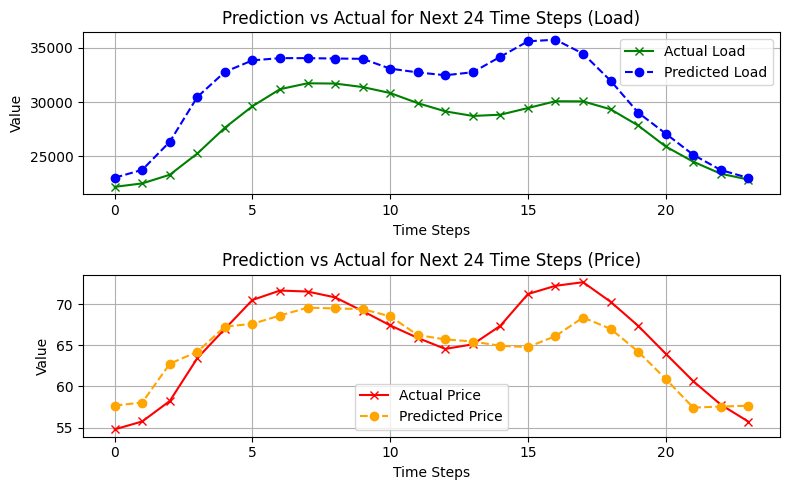

In [46]:
fig, axs = plt.subplots(2, 1, figsize=(8, 5))
axs[0].plot(inversed_predicted_load[199,:], label='Actual Load', linestyle='-', marker='x', c='green')
axs[0].plot(inversed_actual_load[199,:], label='Predicted Load', linestyle='--', marker='o', c='blue')

axs[0].set_title(f'Prediction vs Actual for Next 24 Time Steps (Load)')
axs[0].set_xlabel('Time Steps')

axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(inversed_predicted_price[199,:], label='Actual Price', linestyle='-', marker='x', c='red')
axs[1].plot(inversed_actual_price[199,:], label='Predicted Price', linestyle='--', marker='o', c='orange')

axs[1].set_title(f'Prediction vs Actual for Next 24 Time Steps (Price)')
axs[1].set_xlabel('Time Steps')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
inversed_actual_load.shape

(2439, 24)

In [ ]:
inversed_predicted_price.shape

(2439, 24)

In [ ]:
multi_load_mse = mean_squared_error(inversed_actual_load, inversed_predicted_load)
multi_load_mae = mean_absolute_error(inversed_actual_load, inversed_predicted_load)

In [ ]:
print(f"Multi-Step Load MSE: {multi_load_mse:.4f}")
print(f"Multi-Step Load MAE: {multi_load_mae:.4f}")

Multi-Step Load MSE: 35216124.0000
Multi-Step Load MAE: 4843.2051


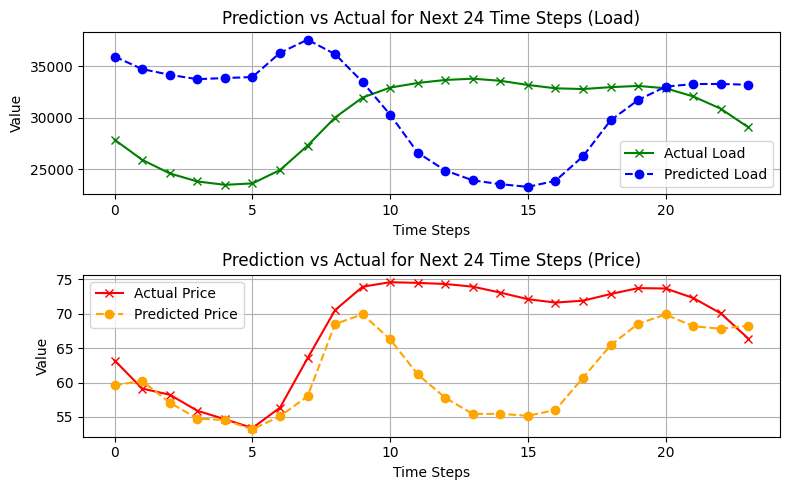

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8, 5))
axs[0].plot(inversed_predicted_load[20,:], label='Actual Load', linestyle='-', marker='x', c='green')
axs[0].plot(inversed_actual_load[20,:], label='Predicted Load', linestyle='--', marker='o', c='blue')

axs[0].set_title(f'Prediction vs Actual for Next 24 Time Steps (Load)')
axs[0].set_xlabel('Time Steps')

axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(inversed_predicted_price[20,:], label='Actual Price', linestyle='-', marker='x', c='red')
axs[1].plot(inversed_actual_price[20,:], label='Predicted Price', linestyle='--', marker='o', c='orange')

axs[1].set_title(f'Prediction vs Actual for Next 24 Time Steps (Price)')
axs[1].set_xlabel('Time Steps')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
multi_model.save('third_multi_step_model.h5')

In [ ]:
# Second try

def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size, forecast_size, input_cols, output_cols, column_names):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series, not necessarily univariate
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer_size(int) - buffer size to use for the shuffle method
      input_columns (list of str or int) - the names or indices of the columns to be used as features
      output_columns (str or int) - the name or index of the column to be used as the label
      column_names (list of str, optional) - the names of the columns in the series

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # If column names are provided, we track the input_columns and output_columns using their indices in the column list
    if column_names is not None:
        input_cols = [column_names.index(col) if isinstance(col, str) else col for col in input_cols]
        output_cols = [column_names.index(col) if isinstance(col, str) else col for col in output_cols]
    else:
        # If no column names are provided, assume feature_columns and label_columns are indices
        raise ValueError(f"column_names are missing")

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + forecast_size, shift=1, drop_remainder=True) # This is different from single step model: "+ forecast_size"

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + forecast_size))

    # Create tuples with specified features and label
    dataset = dataset.map(lambda window: (tf.gather(window[:-forecast_size], input_cols, axis=-1),
                                          tf.gather(window[-forecast_size:], output_cols, axis=-1))) # forecast_size=1 refers to single step

    if shuffle_buffer_size is not None:
        dataset = dataset.shuffle(shuffle_buffer_size)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

# Build CNN-LSTM-DNN Model
def create_uncompiled_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', activation='relu',
                              input_shape=[window_size, len(input_cols)]),
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(len(output_cols)),
        tf.keras.layers.Lambda(lambda x: x[:,-forecast_size:,:])
    ])
    return model

def create_model(initial_lr=1e-3):  # Adam works well with a smaller learning rate
    # Set the initial learning rate
    initial_learning_rate = initial_lr

    # Define the learning rate schedule (optional but recommended)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=652,
        decay_rate=0.96,
        staircase=True)

    # Set the optimizer to Adam
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compile the model
    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    return model

In [ ]:
input_cols = train_s.columns.to_list()
output_cols = ['total load actual scaled', 'price actual scaled']
column_names = train_s.columns.to_list()

# Parameters
window_size = 24 * 7
batch_size = 32
shuffle_buffer_size = 1000 # this value depends on the size of the data, around the len(data) for small data and small len(data) for big data
forecast_size = 24


train_set = windowed_dataset(train_s, window_size,
                             batch_size,
                             shuffle_buffer_size,
                             forecast_size,
                             input_cols,
                             output_cols,
                             column_names)
valid_set = windowed_dataset(series = valid_s,
                             window_size = window_size,
                             batch_size = batch_size,
                             shuffle_buffer_size = shuffle_buffer_size,
                             forecast_size = forecast_size,
                             input_cols = input_cols,
                             output_cols = output_cols,
                             column_names = column_names)

In [ ]:
multi_model = create_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = multi_model.fit(train_set, validation_data=valid_set, epochs=10, callbacks=[early_stopping])

Epoch 1/10
    652/Unknown 274s 411ms/step - loss: 0.0089 - mae: 0.0944

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


652/652 ━━━━━━━━━━━━━━━━━━━━ 286s 429ms/step - loss: 0.0089 - mae: 0.0944 - val_loss: 0.0054 - val_mae: 0.0766
Epoch 2/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 281s 431ms/step - loss: 0.0044 - mae: 0.0677 - val_loss: 0.0053 - val_mae: 0.0681
Epoch 3/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 330s 444ms/step - loss: 0.0040 - mae: 0.0641 - val_loss: 0.0051 - val_mae: 0.0671
Epoch 4/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 316s 435ms/step - loss: 0.0038 - mae: 0.0626 - val_loss: 0.0046 - val_mae: 0.0678
Epoch 5/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 324s 438ms/step - loss: 0.0035 - mae: 0.0597 - val_loss: 0.0042 - val_mae: 0.0635
Epoch 6/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 321s 437ms/step - loss: 0.0034 - mae: 0.0590 - val_loss: 0.0039 - val_mae: 0.0597
Epoch 7/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 288s 441ms/step - loss: 0.0030 - mae: 0.0551 - val_loss: 0.0036 - val_mae: 0.0556
Epoch 8/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 323s 442ms/step - loss: 0.0029 - mae: 0.0539 - val_loss: 0.0050 - val_mae: 0.0676
Epoch 9/10
652/652 ━━━━━━━━━━━━━━━━

In [ ]:
multi_model.save('multi_step_model.h5')

In [ ]:
valid_input = valid_set.map(lambda x, y: x)
valid_predictions = multi_model.predict(valid_input)

valid_actual_labels = np.concatenate([y.numpy() for x, y in valid_set]) # Extract outputs and convert it to a NumPy array from tensor format

77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step


In [ ]:
# You need to reshape it so that you can inverse scale each feature separately
predicted_load = valid_predictions[:, :, 0].reshape(-1, 1)  # Load predictions
predicted_price = valid_predictions[:, :, 1].reshape(-1, 1)  # Price predictions

# Apply inverse transform using the corresponding scalers
inversed_predicted_load = load_scaler.inverse_transform(predicted_load)
inversed_predicted_load = inversed_predicted_load.reshape(valid_predictions.shape[0], valid_predictions.shape[1])

inversed_predicted_price = price_scaler.inverse_transform(predicted_price)
inversed_predicted_price = inversed_predicted_price.reshape(valid_predictions.shape[0], valid_predictions.shape[1])

actual_load = valid_actual_labels[:, :, 0].reshape(-1, 1)  # Load predictions
actual_price = valid_actual_labels[:, :, 1].reshape(-1, 1)  # Price predictions

inversed_actual_load = load_scaler.inverse_transform(actual_load)
inversed_actual_load = inversed_actual_load.reshape(valid_predictions.shape[0], valid_predictions.shape[1])

inversed_actual_price = price_scaler.inverse_transform(actual_price)
inversed_actual_price = inversed_actual_price.reshape(valid_predictions.shape[0], valid_predictions.shape[1])



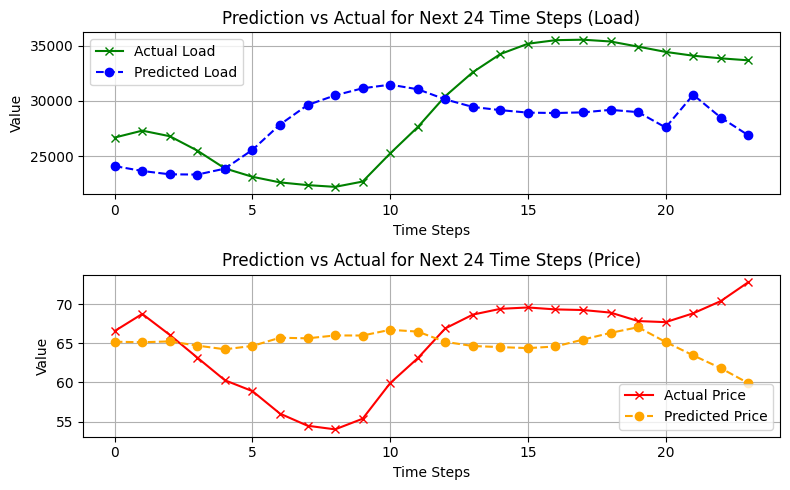

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8, 5))
axs[0].plot(inversed_predicted_load[0,:], label='Actual Load', linestyle='-', marker='x', c='green')
axs[0].plot(inversed_actual_load[0,:], label='Predicted Load', linestyle='--', marker='o', c='blue')

axs[0].set_title(f'Prediction vs Actual for Next 24 Time Steps (Load)')
axs[0].set_xlabel('Time Steps')

axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(inversed_predicted_price[0,:], label='Actual Price', linestyle='-', marker='x', c='red')
axs[1].plot(inversed_actual_price[0,:], label='Predicted Price', linestyle='--', marker='o', c='orange')

axs[1].set_title(f'Prediction vs Actual for Next 24 Time Steps (Price)')
axs[1].set_xlabel('Time Steps')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Save models

model.save('multi_step_model.h5')

If the model performs good on the validation set, we move on to predict future values. Firstly, we re-train the full dataset including  training set and validation set

In [ ]:
full_dataset = pd.concat([train, valid])

dfull_train_load = xgb.DMatrix(full_dataset.drop(['total load actual', 'price actual'], axis=1), label=full_dataset['total load actual'])
dfull_train_price = xgb.DMatrix(full_dataset.drop(['total load actual', 'price actual'], axis=1), label=full_dataset['price actual'])

load_model= xgb.train(
    params=parameters,
    dtrain=dfull_train_load,
    num_boost_round=7570,
)

price_model= xgb.train(
    params=parameters,
    dtrain=dfull_train_price,
    num_boost_round=1081,
)

In [ ]:
last_rows = train[-window_size:].copy()


In [ ]:
window_size = 24

# Iterate through each hour in the extended data
for i in range(1, 25):
    for j in range(1, window_size):
        # Directly assign to the DataFrame using `.iloc`
        extended_data.iloc[i, extended_data.columns.get_loc(f'load_lag_{j+1}')] = extended_data.iloc[i-1, extended_data.columns.get_loc(f'load_lag_{j}')]
        extended_data.iloc[i, extended_data.columns.get_loc(f'price_lag_{j+1}')] = extended_data.iloc[i-1, extended_data.columns.get_loc(f'price_lag_{j}')]
    extended_data.iloc[i, extended_data.columns.get_loc('load_lag_1')] = extended_data.iloc[i-1, extended_data.columns.get_loc('load_lag_1')]
    extended_data.iloc[i, extended_data.columns.get_loc('price_lag_1')] = extended_data.iloc[i-1, extended_data.columns.get_loc('price_lag_1')]

    last_inputs = extended_data.iloc[[i-1]].copy()
    last_inputs = last_inputs.drop(['total load actual', 'price actual'], axis=1)
    dtrain = xgb.DMatrix(last_inputs)
    load = load_model.predict(dtrain)
    price = price_model.predict(dtrain)

    extended_data.iloc[i, extended_data.columns.get_loc('total load actual')] = load[0]
    extended_data.iloc[i, extended_data.columns.get_loc('price actual')] = price[0]

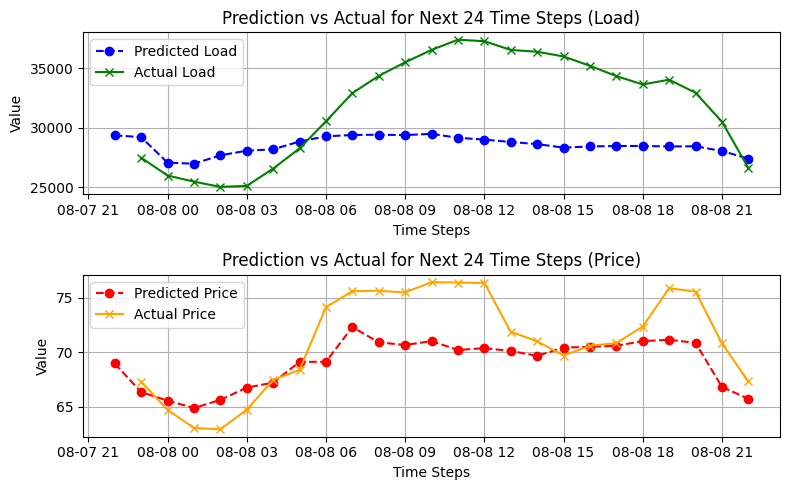

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8, 5))

axs[0].plot(extended_data['total load actual'], label='Predicted Load', linestyle='--', marker='o', c='blue')
axs[0].plot(test[:24]['total load actual'], label='Actual Load', linestyle='-', marker='x', c='green')


axs[0].set_title(f'Prediction vs Actual for Next 24 Time Steps (Load)')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(extended_data['price actual'], label='Predicted Price', linestyle='--', marker='o', c='red')
axs[1].plot(test[:24]['price actual'], label='Actual Price', linestyle='-', marker='x', c= 'orange')
axs[1].set_title(f'Prediction vs Actual for Next 24 Time Steps (Price)')
axs[1].set_xlabel('Time Steps')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

## 4. Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Reshape the predictions and valid outputs to 2D
# This flattens the windows and time steps into a single dimension
prediction_reshaped = prediction.reshape(-1, prediction.shape[-1])  # Shape: (6966*24, 2)
test_output_reshaped = test_output.reshape(-1, test_output.shape[-1])  # Shape: (6966*24, 2)

# Revert the predictions and actual values to their original scales
prediction_reshaped[:, 0] = load_scaler.inverse_transform(prediction_reshaped[:, 0].reshape(-1, 1)).flatten()
prediction_reshaped[:, 1] = price_scaler.inverse_transform(prediction_reshaped[:, 1].reshape(-1, 1)).flatten()

test_output_reshaped[:, 0] = load_scaler.inverse_transform(test_output_reshaped[:, 0].reshape(-1, 1)).flatten()
test_output_reshaped[:, 1] = price_scaler.inverse_transform(test_output_reshaped[:, 1].reshape(-1, 1)).flatten()

# Calculate MSE for each target
mse_load = mean_squared_error(test_output_reshaped[:, 0], prediction_reshaped[:, 0])
mse_price = mean_squared_error(test_output_reshaped[:, 1], prediction_reshaped[:, 1])

# Calculate MAE for each target
mae_load = mean_absolute_error(test_output_reshaped[:, 0], prediction_reshaped[:, 0])
mae_price = mean_absolute_error(test_output_reshaped[:, 1], prediction_reshaped[:, 1])

# Print the MSE results
print(f'MSE for Load: {mse_load}')
print(f'MSE for Price: {mse_price}')

# Print the MAe results
print(f'MAE for Load: {mae_load}')
print(f'MAE for Price: {mae_price}')

MSE for Load: 7109858.220131684
MSE for Price: 32.32858569674062
MAE for Load: 2032.1090146865224
MAE for Price: 4.537975513299491


## 5. Deployment and Prediction

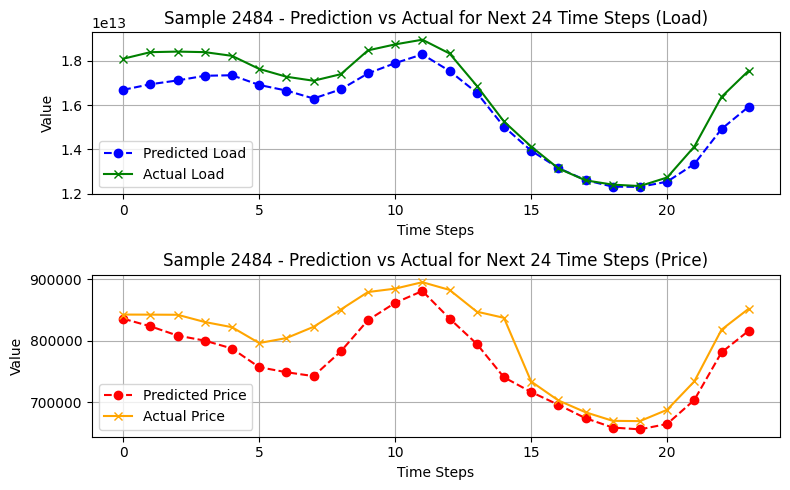

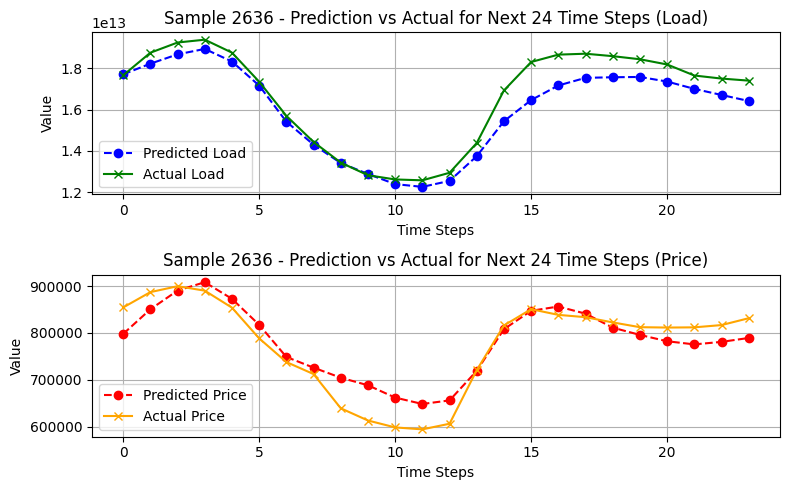

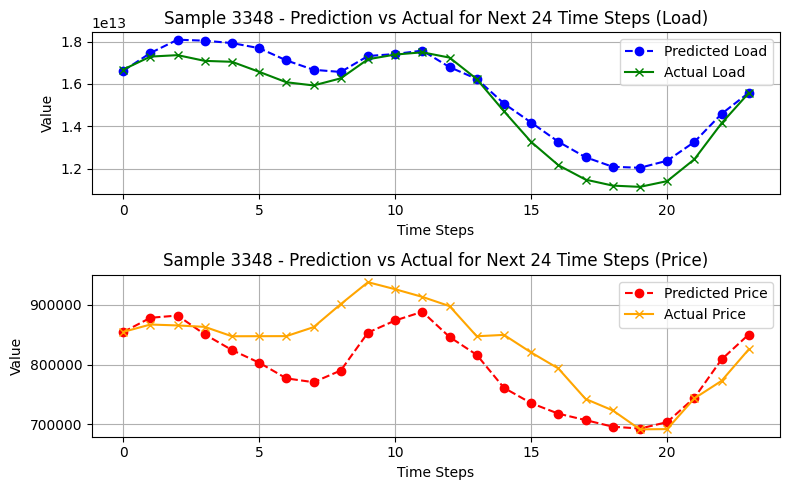

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Randomly select 3 samples (indices) from the reshaped predictions and valid outputs
num_samples = prediction.shape[0]  # This is 6966 based on your description
random_indices = np.random.choice(num_samples, 3, replace=False)

# Plot predictions vs actual values for the selected samples in original scale
for i, idx in enumerate(random_indices):
    # Revert the predictions and actual values for the selected sample
    original_prediction_load = load_scaler.inverse_transform(prediction[idx, :, 0].reshape(-1, 1)).flatten()
    original_actual_load = load_scaler.inverse_transform(test_output[idx, :, 0].reshape(-1, 1)).flatten()

    original_prediction_price = price_scaler.inverse_transform(prediction[idx, :, 1].reshape(-1, 1)).flatten()
    original_actual_price = price_scaler.inverse_transform(test_output[idx, :, 1].reshape(-1, 1)).flatten()

    fig, axs = plt.subplots(2, 1, figsize=(8, 5))

    axs[0].plot(original_prediction_load, label='Predicted Load', linestyle='--', marker='o', c='blue')
    axs[0].plot(original_actual_load, label='Actual Load', linestyle='-', marker='x', c='green')
    axs[0].set_title(f'Sample {idx} - Prediction vs Actual for Next 24 Time Steps (Load)')
    axs[0].set_xlabel('Time Steps')
    axs[0].set_ylabel('Value')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(original_prediction_price, label='Predicted Price', linestyle='--', marker='o', c='red')
    axs[1].plot(original_actual_price, label='Actual Price', linestyle='-', marker='x', c= 'orange')
    axs[1].set_title(f'Sample {idx} - Prediction vs Actual for Next 24 Time Steps (Price)')
    axs[1].set_xlabel('Time Steps')
    axs[1].set_ylabel('Value')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

